**这个Notebook需要dmg文件夹中文件, 其他函数在Notebook中定义.**

## Package Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg

## Define R, P, Poisson, Nonlinear Poisson

In [2]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    outputsize = int((2**(np.log2(np.sqrt(inputsize)+1)-1)-1)**2)
    sqrtoutputsize = int(np.sqrt(outputsize))
    OUTPUT = np.zeros([outputsize, inputsize])
    for j in range(sqrtoutputsize):
        for i in range(sqrtoutputsize):
            OUTPUT[i+sqrtoutputsize*j][2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][1+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/4
            OUTPUT[i+sqrtoutputsize*j][2+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2*sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2 *
                                       sqrtinputsize + 2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2 *
                                       sqrtinputsize+2*i+j*2*sqrtinputsize] = 1/16
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    A1 = 2*np.eye(sqrtinputsize)
    for i in range(sqrtinputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    I = np.eye(sqrtinputsize)
    OUTPUT = (np.kron(I, A1)+np.kron(A1, I))
    return OUTPUT


def NonlinearPoisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    h = 1/(sqrtinputsize-1)
    KX = np.zeros([inputsize,inputsize+1])
    KY = np.zeros([inputsize+1,inputsize])
    for i in range(sqrtinputsize):
        for j in range(sqrtinputsize+1):
            KX[i][j] = a(j*h-0.5*h,i*h)
    for i in range(sqrtinputsize+1):
        for j in range(sqrtinputsize):
            KY[i][j] = a(j*h,i*h-0.5*h)
    OUTPUT = (gallery.nonlinearPoisson((sqrtinputsize,sqrtinputsize),KX,KY)).to_full()
    return OUTPUT

## Define Multigrid

In [3]:
def Multigrid_circle(inputsize, A_A, B, R_A, s, w, NUM_EPOCH):
    A = np.matrix(A_A)
    P = 4*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    for i in range(NUM_EPOCH):
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

## Define Spectral Radius Calculator

In [4]:
def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def rhoAuto(INPUT):
    R = INPUT[0]
    w = INPUT[1]
    P = 4*np.transpose(R)
    M = (w**(-1)) * np.diag(np.diag(A1))
    K = M - A1
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A1),P))),R),A1)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

## Define Optimizer

In [5]:
def optimizer_GD(inputsize, A, R, w, s, learning_rate):
    rhoold = rho(inputsize,A,4*np.transpose(R),R,w,s)
    INPUT = [R,w]
    rhoGra = grad(rhoAuto)
    delta = rhoGra(INPUT)
    R -= learning_rate*delta[0]
    w -= learning_rate*delta[1]
    rhonew = rho(inputsize,A,4*np.transpose(R),R,w,s)
    return R, w, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate)
        R = Rnew
        w = wnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            P = 4*np.transpose(R)
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhonew <= rhoold and i<100:
        Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate)
        R = Rnew
        Radius.append(Rnew)
        w = wnew
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

In [6]:
finegridsize = 5
s = 1
w = 2/3
MAX_ITER = 50

# Experiment (with large e1, e2, e3, e4, e5)

选取比较大的参数, a函数频率较小

In [7]:
e = 0.1
def u_real(x, y): return np.sin(np.pi*3*x)*np.sin(np.pi*5*y)
def rightf(x, y): return  34*np.pi**2*np.sin(3*np.pi*x)*np.sin(5*np.pi*y)*(np.cos((x + y)/e) + 2) + (3*np.pi*np.cos(3*np.pi*x)*np.sin(5*np.pi*y)*np.sin((x + y)/e))/e + (5*np.pi*np.cos(5*np.pi*y)*np.sin(3*np.pi*x)*np.sin((x + y)/e))/e
def a(x, y): return 2+np.cos((x+y)/e)

**Plot $a(x,y)$**

In [8]:
inputsize = (2**finegridsize-1)**2
inputsize = int(inputsize)
sqrtinputsize = int(np.sqrt(inputsize))
outputsize = int((2**(np.log2(np.sqrt(inputsize)+1)-1)-1)**2)
sqrtoutputsize = int(np.sqrt(outputsize))
h = 1/(sqrtinputsize-1)
A0 = Poisson(inputsize)
A1 = NonlinearPoisson(inputsize)
[X, Y] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
RightF = rightf(X,Y)*h**2
RightF = RightF.reshape(inputsize, 1)
Ureal = u_real(X,Y).reshape(inputsize, 1)
R = Restriction(inputsize)
P = 4*np.transpose(R)

**Plot A0, A1**

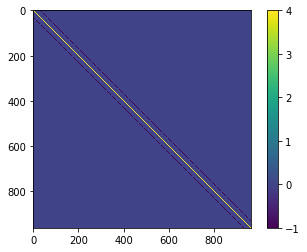

In [9]:
plt.imshow(A0)
plt.colorbar()

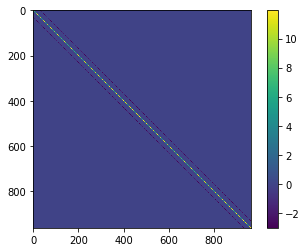

In [10]:
plt.imshow(A1)
plt.colorbar()


## GMM

**Calculate Result and Residual**

In [11]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A1, RightF, R, s, w, MAX_ITER)

Residual = 11.076930573884393
Interation = 0
Residual = 1.2275732484089246
Interation = 1
Residual = 0.24997520263616746
Interation = 2
Residual = 0.06580328167238073
Interation = 3
Residual = 0.021878710787429784
Interation = 4
Residual = 0.008158544640390477
Interation = 5
Residual = 0.0031843134948528486
Interation = 6
Residual = 0.0012693365115313928
Interation = 7
Residual = 0.0005122275586902024
Interation = 8
Residual = 0.00020843594572974417
Interation = 9
Residual = 8.534485147941583e-05
Interation = 10
Residual = 3.511530047930404e-05
Interation = 11
Residual = 1.4505578272504364e-05
Interation = 12
Residual = 6.011871967975948e-06
Interation = 13
Residual = 2.498666267891644e-06
Interation = 14
Residual = 1.0410382818515291e-06
Interation = 15
Residual = 4.346653202842733e-07
Interation = 16
Residual = 1.818308921556153e-07
Interation = 17
Residual = 7.619346275793307e-08
Interation = 18
Residual = 3.197660330419626e-08
Interation = 19
Residual = 1.3438476294947267e-08
Inter

In [12]:
np.linalg.norm(Ureal - GMM_U,np.inf)

0.4097561189729528

**Plot Result**

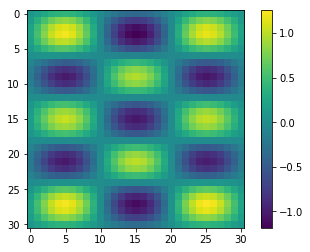

In [13]:
plt.imshow(GMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

**Plot Residual**

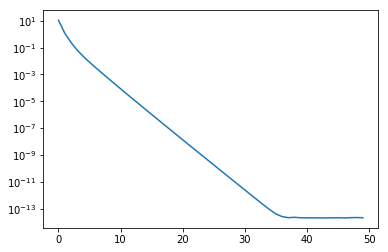

In [14]:
plt.semilogy(GMM_Res)

**Calculate Spectral Radius**

In [15]:
GMM_Radius = rho(inputsize,A1,4*np.transpose(R),R,w,s)
print('GMM_Radius = {}'.format(GMM_Radius))

GMM_Radius = 0.45448711446488443


## AMG

**Define Solver and Solve**

In [16]:
amg_solver = pyamg.classical.classical.ruge_stuben_solver(A1,max_levels = 2)
pyamg.relaxation.smoothing.change_smoothers(amg_solver,presmoother=("jacobi", {"omega": w, "iterations": s}),postsmoother=("jacobi", {"omega": w, "iterations": s}))
AMG_Res = []
print(amg_solver)
AMG_U= amg_solver.solve(RightF, maxiter = MAX_ITER, tol=0, residuals=AMG_Res)

multilevel_solver
Number of Levels:     2
Operator Complexity:  1.872
Grid Complexity:      1.501
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0          961         4681 [53.42%]
    1          481         4081 [46.58%]



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pyamg/classical/classical.py:98: SparseEfficiencyWarning: Implicit conversion of A to CSR
  SparseEfficiencyWarning)


**Plot Result**

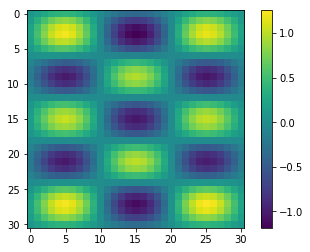

In [17]:
plt.imshow(AMG_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

**Plot Residual**

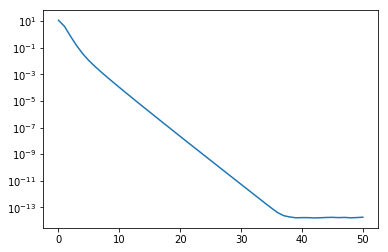

In [18]:
plt.semilogy(AMG_Res)

## DMM with full R optimization

**Optimize R, P, $\omega$**

learning_rate是梯度下降时步长, step_length是每一个M之间的距离, 两者都必须非常小, 不然会出现不好的结果.

In [19]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1, Restriction(inputsize),  2/3, s, learning_rate = 1e-1,accept_radius = GMM_Radius,step_length = 1e-1)

======Section 1======
L = 0.2
rho = 0.4120877108589604
Decrease the step_length, learning_rate and Restart!!
step_length = 0.010000000000000002
learning_rate = 0.010000000000000002
rhonew = 0.987728588587022
L = 0.020000000000000004
rho = 0.44923785543252254
L = 0.030000000000000006
rho = 0.4443994247734256
L = 0.04000000000000001
rho = 0.4397143394469528
L = 0.05000000000000001
rho = 0.43501785159601786
L = 0.06000000000000001
rho = 0.43078557170404164
L = 0.07
rho = 0.42822396708383637
Decrease the step_length, learning_rate and Restart!!
step_length = 0.0010000000000000002
learning_rate = 0.0010000000000000002
rhonew = 0.49404240749519857
L = 0.0020000000000000005
rho = 0.4535930079553249
L = 0.003000000000000001
rho = 0.45310542419518907
L = 0.004000000000000001
rho = 0.452618482442061
L = 0.005000000000000001
rho = 0.4521320658516785
L = 0.006000000000000001
rho = 0.4516461277809514
L = 0.007000000000000001
rho = 0.45116065596064514
L = 0.008000000000000002
rho = 0.450675653744741

L = 0.10800000000000008
rho = 0.4047930149622826
L = 0.10900000000000008
rho = 0.4043596174271925
L = 0.11000000000000008
rho = 0.40392670336840025
L = 0.11100000000000008
rho = 0.4034942722118301
L = 0.11200000000000009
rho = 0.4030623233843806
L = 0.11300000000000009
rho = 0.4026308563139189
L = 0.11400000000000009
rho = 0.40219987042927413
L = 0.11500000000000009
rho = 0.40176936516023093
L = 0.11600000000000009
rho = 0.40133933993752324
L = 0.11700000000000009
rho = 0.4009097941928281
L = 0.11800000000000009
rho = 0.4004807273587594
L = 0.11900000000000009
rho = 0.40005213886886243
L = 0.12000000000000009
rho = 0.399624028157607
L = 0.1210000000000001
rho = 0.399196394660383
L = 0.1220000000000001
rho = 0.39876923781349316
L = 0.1230000000000001
rho = 0.39834255705414867
L = 0.1240000000000001
rho = 0.39791635182046303
L = 0.12500000000000008
rho = 0.39749062155144665
L = 0.12600000000000008
rho = 0.3970653656870016
L = 0.12700000000000009
rho = 0.39664058366791666
L = 0.1280000000

L = 0.00020000000000000006
rho = 0.45403259947030583
L = 0.0003000000000000001
rho = 0.4539837220603661
L = 0.00040000000000000013
rho = 0.45393485571722125
L = 0.0005000000000000001
rho = 0.4538860000340409
L = 0.0006000000000000002
rho = 0.45383715462770857
L = 0.0007000000000000002
rho = 0.4537883191375252
L = 0.0008000000000000003
rho = 0.4537394932239826
L = 0.0009000000000000003
rho = 0.4536906765676042
L = 0.0010000000000000002
rho = 0.45364186886784763
L = 0.0011000000000000003
rho = 0.45359306984206715
L = 0.0012000000000000003
rho = 0.45354427922453294
L = 0.0013000000000000004
rho = 0.45349549676550127
L = 0.0014000000000000004
rho = 0.45344672223033716
L = 0.0015000000000000005
rho = 0.45339795539868155
L = 0.0016000000000000005
rho = 0.4533491960636653
L = 0.0017000000000000006
rho = 0.45330044403116465
L = 0.0018000000000000006
rho = 0.45325169911909563
L = 0.0019000000000000006
rho = 0.4532029611567482
L = 0.0020000000000000005
rho = 0.453154229984154
L = 0.0021000000000

L = 0.011999999999999983
rho = 0.44830748877225807
L = 0.012099999999999982
rho = 0.4482592752983957
L = 0.012199999999999982
rho = 0.4482110670058057
L = 0.012299999999999981
rho = 0.448162863898815
L = 0.01239999999999998
rho = 0.4481146659816563
L = 0.01249999999999998
rho = 0.44806647325846866
L = 0.01259999999999998
rho = 0.44801828573329877
L = 0.012699999999999979
rho = 0.447970103410102
L = 0.012799999999999978
rho = 0.4479219262927434
L = 0.012899999999999977
rho = 0.44787375438499827
L = 0.012999999999999977
rho = 0.447825587690554
L = 0.013099999999999976
rho = 0.4477774262130109
L = 0.013199999999999976
rho = 0.4477292699558832
L = 0.013299999999999975
rho = 0.447681118922601
L = 0.013399999999999974
rho = 0.44763297311651007
L = 0.013499999999999974
rho = 0.447584832540875
L = 0.013599999999999973
rho = 0.4475366971988784
L = 0.013699999999999973
rho = 0.44748856709362406
L = 0.013799999999999972
rho = 0.44744044222813684
L = 0.013899999999999971
rho = 0.4473923226053645
L

L = 0.02379999999999991
rho = 0.44265469374551464
L = 0.02389999999999991
rho = 0.44260710481665
L = 0.02399999999999991
rho = 0.4425595212092473
L = 0.02409999999999991
rho = 0.4425119429230676
L = 0.02419999999999991
rho = 0.44246436995786437
L = 0.02429999999999991
rho = 0.4424168023133836
L = 0.024399999999999908
rho = 0.4423692399893645
L = 0.024499999999999907
rho = 0.4423216829855395
L = 0.024599999999999907
rho = 0.442274131301634
L = 0.024699999999999906
rho = 0.4422265849373673
L = 0.024799999999999905
rho = 0.44217904389245166
L = 0.024899999999999905
rho = 0.44213150816659347
L = 0.024999999999999904
rho = 0.4420839777594931
L = 0.025099999999999904
rho = 0.4420364526708447
L = 0.025199999999999903
rho = 0.4419889329003366
L = 0.025299999999999902
rho = 0.4419414184476515
L = 0.025399999999999902
rho = 0.44189390931246664
L = 0.0254999999999999
rho = 0.4418464054944534
L = 0.0255999999999999
rho = 0.4417989069932783
L = 0.0256999999999999
rho = 0.44175141380860233
L = 0.025

L = 0.03559999999999999
rho = 0.4370758337152216
L = 0.035699999999999996
rho = 0.43702886991138434
L = 0.0358
rho = 0.43698191137519277
L = 0.0359
rho = 0.43693495810608557
L = 0.036000000000000004
rho = 0.4368880101035005
L = 0.03610000000000001
rho = 0.43684106736687467
L = 0.03620000000000001
rho = 0.43679412989564437
L = 0.03630000000000001
rho = 0.43674719768924514
L = 0.036400000000000016
rho = 0.43670027074711176
L = 0.03650000000000002
rho = 0.43665334906867825
L = 0.03660000000000002
rho = 0.4366064326533778
L = 0.036700000000000024
rho = 0.4365595215006429
L = 0.03680000000000003
rho = 0.4365126156099053
L = 0.03690000000000003
rho = 0.436465714980596
L = 0.03700000000000003
rho = 0.43641881961214546
L = 0.037100000000000036
rho = 0.43637192950398307
L = 0.03720000000000004
rho = 0.43632504465553806
L = 0.03730000000000004
rho = 0.4362781650662383
L = 0.037400000000000044
rho = 0.43623129073551165
L = 0.03750000000000005
rho = 0.43618442166278465
L = 0.03760000000000005
rho 

L = 0.04740000000000033
rho = 0.43157031279137353
L = 0.047500000000000334
rho = 0.43152396653787223
L = 0.047600000000000336
rho = 0.43147762548211416
L = 0.04770000000000034
rho = 0.4314312896234875
L = 0.04780000000000034
rho = 0.43138495896137996
L = 0.047900000000000345
rho = 0.43133863349517887
L = 0.04800000000000035
rho = 0.43129231322427175
L = 0.04810000000000035
rho = 0.4312459981480455
L = 0.048200000000000354
rho = 0.43119968826588745
L = 0.04830000000000036
rho = 0.43115338357718425
L = 0.04840000000000036
rho = 0.4311070840813225
L = 0.04850000000000036
rho = 0.4310607897776888
L = 0.048600000000000365
rho = 0.4310145006656694
L = 0.04870000000000037
rho = 0.4309682167446504
L = 0.04880000000000037
rho = 0.43092193801401807
L = 0.048900000000000374
rho = 0.43087566447315784
L = 0.04900000000000038
rho = 0.43082939612145577
L = 0.04910000000000038
rho = 0.4307831329582972
L = 0.04920000000000038
rho = 0.4307368749830675
L = 0.049300000000000385
rho = 0.43069062219515214
L

L = 0.05920000000000067
rho = 0.4261371705084329
L = 0.05930000000000067
rho = 0.4260914333313081
L = 0.059400000000000674
rho = 0.42604570127900127
L = 0.05950000000000068
rho = 0.4259999743508924
L = 0.05960000000000068
rho = 0.4259542525463614
L = 0.05970000000000068
rho = 0.4259085358647885
L = 0.059800000000000686
rho = 0.42586282430555367
L = 0.05990000000000069
rho = 0.4258171178680373
L = 0.06000000000000069
rho = 0.4257714165516191
L = 0.060100000000000695
rho = 0.4257257203556796
L = 0.0602000000000007
rho = 0.4256800292795988
L = 0.0603000000000007
rho = 0.42563434332275696
L = 0.0604000000000007
rho = 0.42558866248453436
L = 0.060500000000000706
rho = 0.4255429867643113
L = 0.06060000000000071
rho = 0.4254973161614681
L = 0.06070000000000071
rho = 0.4254516506753849
L = 0.060800000000000715
rho = 0.42540599030544224
L = 0.06090000000000072
rho = 0.4253603350510205
L = 0.06100000000000072
rho = 0.4253146849115002
L = 0.06110000000000072
rho = 0.42526903988626175
L = 0.061200

L = 0.07110000000000101
rho = 0.4207302583372919
L = 0.07120000000000101
rho = 0.4206851266729006
L = 0.07130000000000102
rho = 0.42064000005991087
L = 0.07140000000000102
rho = 0.42059487849771005
L = 0.07150000000000102
rho = 0.420549761985686
L = 0.07160000000000102
rho = 0.4205046505232264
L = 0.07170000000000103
rho = 0.4204595441097188
L = 0.07180000000000103
rho = 0.42041444274455153
L = 0.07190000000000103
rho = 0.4203693464271123
L = 0.07200000000000104
rho = 0.4203242551567894
L = 0.07210000000000104
rho = 0.4202791689329709
L = 0.07220000000000104
rho = 0.42023408775504506
L = 0.07230000000000104
rho = 0.4201890116224004
L = 0.07240000000000105
rho = 0.42014394053442533
L = 0.07250000000000105
rho = 0.42009887449050837
L = 0.07260000000000105
rho = 0.42005381349003834
L = 0.07270000000000106
rho = 0.42000875753240385
L = 0.07280000000000106
rho = 0.4199637066169938
L = 0.07290000000000106
rho = 0.41991866074319706
L = 0.07300000000000106
rho = 0.41987361991040284
L = 0.07310

L = 0.08300000000000135
rho = 0.41539488923529616
L = 0.08310000000000135
rho = 0.41535035441456636
L = 0.08320000000000136
rho = 0.41530582457305754
L = 0.08330000000000136
rho = 0.4152612997101695
L = 0.08340000000000136
rho = 0.41521677982530203
L = 0.08350000000000136
rho = 0.415172264917855
L = 0.08360000000000137
rho = 0.41512775498722865
L = 0.08370000000000137
rho = 0.4150832500328232
L = 0.08380000000000137
rho = 0.4150387500540388
L = 0.08390000000000138
rho = 0.4149942550502758
L = 0.08400000000000138
rho = 0.414949765020935
L = 0.08410000000000138
rho = 0.41490527996541665
L = 0.08420000000000138
rho = 0.41486079988312186
L = 0.08430000000000139
rho = 0.41481632477345104
L = 0.08440000000000139
rho = 0.41477185463580546
L = 0.0845000000000014
rho = 0.41472738946958604
L = 0.0846000000000014
rho = 0.41468292927419387
L = 0.0847000000000014
rho = 0.41463847404903037
L = 0.0848000000000014
rho = 0.41459402379349675
L = 0.0849000000000014
rho = 0.41454957850699464
L = 0.0850000

L = 0.09490000000000169
rho = 0.4101300411783532
L = 0.0950000000000017
rho = 0.4100860947001785
L = 0.0951000000000017
rho = 0.4100421531305532
L = 0.0952000000000017
rho = 0.40999821646888995
L = 0.0953000000000017
rho = 0.4099542847146014
L = 0.0954000000000017
rho = 0.4099103578671003
L = 0.09550000000000171
rho = 0.4098664359257995
L = 0.09560000000000171
rho = 0.40982251889011206
L = 0.09570000000000171
rho = 0.4097786067594508
L = 0.09580000000000172
rho = 0.4097346995332291
L = 0.09590000000000172
rho = 0.4096907972108603
L = 0.09600000000000172
rho = 0.4096468997917577
L = 0.09610000000000173
rho = 0.4096030072753349
L = 0.09620000000000173
rho = 0.40955911966100533
L = 0.09630000000000173
rho = 0.40951523694818276
L = 0.09640000000000173
rho = 0.40947135913628097
L = 0.09650000000000174
rho = 0.4094274862247139
L = 0.09660000000000174
rho = 0.4093836182128957
L = 0.09670000000000174
rho = 0.40933975510024023
L = 0.09680000000000175
rho = 0.40929589688616197
L = 0.096900000000

L = 0.10680000000000203
rho = 0.40493471317370366
L = 0.10690000000000204
rho = 0.4048913467168652
L = 0.10700000000000204
rho = 0.40484798509939474
L = 0.10710000000000204
rho = 0.404804628320717
L = 0.10720000000000204
rho = 0.4047612763802568
L = 0.10730000000000205
rho = 0.40471792927743905
L = 0.10740000000000205
rho = 0.4046745870116888
L = 0.10750000000000205
rho = 0.40463124958243085
L = 0.10760000000000206
rho = 0.4045879169890908
L = 0.10770000000000206
rho = 0.40454458923109365
L = 0.10780000000000206
rho = 0.4045012663078648
L = 0.10790000000000206
rho = 0.40445794821882997
L = 0.10800000000000207
rho = 0.40441463496341445
L = 0.10810000000000207
rho = 0.40437132654104413
L = 0.10820000000000207
rho = 0.40432802295114467
L = 0.10830000000000208
rho = 0.40428472419314193
L = 0.10840000000000208
rho = 0.4042414302664621
L = 0.10850000000000208
rho = 0.404198141170531
L = 0.10860000000000208
rho = 0.4041548569047749
L = 0.10870000000000209
rho = 0.40411157746862003
L = 0.10880

L = 0.11870000000000237
rho = 0.3998079252550834
L = 0.11880000000000238
rho = 0.3997651306703226
L = 0.11890000000000238
rho = 0.39972234085714353
L = 0.11900000000000238
rho = 0.3996795558149821
L = 0.11910000000000238
rho = 0.3996367755432745
L = 0.11920000000000239
rho = 0.39959400004145673
L = 0.11930000000000239
rho = 0.3995512293089651
L = 0.1194000000000024
rho = 0.3995084633452361
L = 0.1195000000000024
rho = 0.399465702149706
L = 0.1196000000000024
rho = 0.3994229457218115
L = 0.1197000000000024
rho = 0.3993801940609892
L = 0.1198000000000024
rho = 0.3993374471666756
L = 0.11990000000000241
rho = 0.3992947050383078
L = 0.12000000000000241
rho = 0.3992519676753225
L = 0.12010000000000241
rho = 0.3992092350771567
L = 0.12020000000000242
rho = 0.39916650724324765
L = 0.12030000000000242
rho = 0.39912378417303224
L = 0.12040000000000242
rho = 0.399081065865948
L = 0.12050000000000242
rho = 0.39903835232143225
L = 0.12060000000000243
rho = 0.3989956435389224
L = 0.1207000000000024

L = 0.13060000000000194
rho = 0.39474871722216265
L = 0.13070000000000193
rho = 0.39470648652029117
L = 0.13080000000000191
rho = 0.39466426052351117
L = 0.1309000000000019
rho = 0.3946220392312689
L = 0.1310000000000019
rho = 0.3945798226430111
L = 0.13110000000000188
rho = 0.39453761075818433
L = 0.13120000000000187
rho = 0.39449540357623547
L = 0.13130000000000186
rho = 0.3944532010966112
L = 0.13140000000000185
rho = 0.3944110033187586
L = 0.13150000000000184
rho = 0.39436881024212456
L = 0.13160000000000183
rho = 0.39432662186615625
L = 0.13170000000000182
rho = 0.39428443819030073
L = 0.1318000000000018
rho = 0.3942422592140055
L = 0.1319000000000018
rho = 0.39420008493671765
L = 0.13200000000000178
rho = 0.39415791535788486
L = 0.13210000000000177
rho = 0.39411575047695435
L = 0.13220000000000176
rho = 0.3940735902933741
L = 0.13230000000000175
rho = 0.3940314348065915
L = 0.13240000000000174
rho = 0.3939892840160543
L = 0.13250000000000173
rho = 0.39394713792121056
L = 0.132600

L = 0.14250000000000063
rho = 0.38975614725712554
L = 0.14260000000000062
rho = 0.3897144725980645
L = 0.1427000000000006
rho = 0.3896728025788182
L = 0.1428000000000006
rho = 0.3896311371988427
L = 0.14290000000000058
rho = 0.3895894764575948
L = 0.14300000000000057
rho = 0.38954782035453106
L = 0.14310000000000056
rho = 0.3895061688891082
L = 0.14320000000000055
rho = 0.389464522060783
L = 0.14330000000000054
rho = 0.3894228798690124
L = 0.14340000000000053
rho = 0.3893812423132535
L = 0.14350000000000052
rho = 0.3893396093929629
L = 0.1436000000000005
rho = 0.3892979811075982
L = 0.1437000000000005
rho = 0.38925635745661646
L = 0.14380000000000048
rho = 0.38921473843947485
L = 0.14390000000000047
rho = 0.3891731240556311
L = 0.14400000000000046
rho = 0.38913151430454235
L = 0.14410000000000045
rho = 0.3890899091856663
L = 0.14420000000000044
rho = 0.38904830869846063
L = 0.14430000000000043
rho = 0.38900671284238314
L = 0.14440000000000042
rho = 0.38896512161689156
L = 0.14450000000

L = 0.1544999999999993
rho = 0.38478816455942405
L = 0.1545999999999993
rho = 0.38474704282470784
L = 0.15469999999999928
rho = 0.38470592566536876
L = 0.15479999999999927
rho = 0.38466481308088163
L = 0.15489999999999926
rho = 0.3846237050707215
L = 0.15499999999999925
rho = 0.3845826016343639
L = 0.15509999999999924
rho = 0.3845415027712848
L = 0.15519999999999923
rho = 0.3845004084809606
L = 0.15529999999999922
rho = 0.3844593187628682
L = 0.1553999999999992
rho = 0.38441823361648486
L = 0.1554999999999992
rho = 0.3843771530412885
L = 0.15559999999999918
rho = 0.3843360770367574
L = 0.15569999999999917
rho = 0.38429500560237023
L = 0.15579999999999916
rho = 0.38425393873760677
L = 0.15589999999999915
rho = 0.38421287644194657
L = 0.15599999999999914
rho = 0.38417181871487055
L = 0.15609999999999913
rho = 0.3841307655558596
L = 0.15619999999999912
rho = 0.38408971696439553
L = 0.1562999999999991
rho = 0.38404867293996064
L = 0.1563999999999991
rho = 0.3840076334820378
L = 0.156499999

L = 0.166399999999998
rho = 0.37992666680500453
L = 0.16649999999999798
rho = 0.3798860862639993
L = 0.16659999999999797
rho = 0.37984551025302515
L = 0.16669999999999796
rho = 0.37980493877221067
L = 0.16679999999999795
rho = 0.3797643718217086
L = 0.16689999999999794
rho = 0.37972380940169587
L = 0.16699999999999793
rho = 0.3796832515123751
L = 0.16709999999999792
rho = 0.3796426981539754
L = 0.1671999999999979
rho = 0.37960214932675307
L = 0.1672999999999979
rho = 0.379561605030993
L = 0.16739999999999788
rho = 0.37952106526700935
L = 0.16749999999999787
rho = 0.37948053003514637
L = 0.16759999999999786
rho = 0.3794399993357802
L = 0.16769999999999785
rho = 0.3793994731693194
L = 0.16779999999999784
rho = 0.37935895153620647
L = 0.16789999999999783
rho = 0.37931843443691887
L = 0.16799999999999782
rho = 0.3792779218719702
L = 0.1680999999999978
rho = 0.37923741384191173
L = 0.1681999999999978
rho = 0.3791969103473335
L = 0.16829999999999778
rho = 0.37915641138886613
L = 0.1683999999

L = 0.17829999999999668
rho = 0.375129983457205
L = 0.17839999999999667
rho = 0.3750899693401893
L = 0.17849999999999666
rho = 0.37504996087363157
L = 0.17859999999999665
rho = 0.37500995809952614
L = 0.17869999999999664
rho = 0.3749699610613602
L = 0.17879999999999663
rho = 0.37492996980416604
L = 0.17889999999999662
rho = 0.3748899843745741
L = 0.1789999999999966
rho = 0.3748500048208694
L = 0.1790999999999966
rho = 0.374810031193048
L = 0.17919999999999658
rho = 0.3747700635428776
L = 0.17929999999999657
rho = 0.37473010192395745
L = 0.17939999999999656
rho = 0.3746901463917828
L = 0.17949999999999655
rho = 0.3746501970038107
L = 0.17959999999999654
rho = 0.37461025381952706
L = 0.17969999999999653
rho = 0.374570316900518
L = 0.17979999999999652
rho = 0.3745303863105412
L = 0.1798999999999965
rho = 0.3744904621156021
L = 0.1799999999999965
rho = 0.3744505443840308
L = 0.18009999999999649
rho = 0.3744106331865627
L = 0.18019999999999647
rho = 0.3743707285964212
L = 0.1802999999999964

L = 0.19019999999999537
rho = 0.3704524225993542
L = 0.19029999999999536
rho = 0.37041488264570976
L = 0.19039999999999535
rho = 0.37037741279173664
L = 0.19049999999999534
rho = 0.3703400150908072
L = 0.19059999999999533
rho = 0.37030269165260643
L = 0.19069999999999532
rho = 0.3702654446441638
L = 0.1907999999999953
rho = 0.3702282762908667
L = 0.1908999999999953
rho = 0.37019118887745556
L = 0.19099999999999528
rho = 0.3701541847489928
L = 0.19109999999999527
rho = 0.37011726631180836
L = 0.19119999999999526
rho = 0.3700804360344112
L = 0.19129999999999525
rho = 0.37004369644836865
L = 0.19139999999999524
rho = 0.3700070501491448
L = 0.19149999999999523
rho = 0.3699704997968969
L = 0.19159999999999522
rho = 0.3699340481172226
L = 0.1916999999999952
rho = 0.3698976979018553
L = 0.1917999999999952
rho = 0.36986145200930026
L = 0.19189999999999519
rho = 0.3698253133654081
L = 0.19199999999999517
rho = 0.369789284963879
L = 0.19209999999999516
rho = 0.3697533698666919
L = 0.192199999999

L = 0.20209999999999406
rho = 0.3673633089012152
L = 0.20219999999999405
rho = 0.36735480112862534
L = 0.20229999999999404
rho = 0.3673465398798095
L = 0.20239999999999403
rho = 0.36733851996925587
L = 0.20249999999999402
rho = 0.36733073619538287
L = 0.202599999999994
rho = 0.3673231833482874
L = 0.202699999999994
rho = 0.36731585621724666
L = 0.20279999999999399
rho = 0.3673087495979572
L = 0.20289999999999397
rho = 0.3673018582994948
L = 0.20299999999999396
rho = 0.3672951771509871
L = 0.20309999999999395
rho = 0.3672887010079831
L = 0.20319999999999394
rho = 0.36728242475851625
L = 0.20329999999999393
rho = 0.36727634332884945
L = 0.20339999999999392
rho = 0.3672704516889022
L = 0.2034999999999939
rho = 0.36726474485735167
L = 0.2035999999999939
rho = 0.3672592179064108
L = 0.20369999999999389
rho = 0.3672538659662794
L = 0.20379999999999387
rho = 0.36724868422927226
L = 0.20389999999999386
rho = 0.3672436679536269
L = 0.20399999999999385
rho = 0.36723881246699347
L = 0.20409999999

L = 0.21399999999999275
rho = 0.3670952544689794
L = 0.21409999999999274
rho = 0.3670949542136299
L = 0.21419999999999273
rho = 0.36709465865243296
L = 0.21429999999999272
rho = 0.36709436763641606
L = 0.2143999999999927
rho = 0.3670940810217769
L = 0.2144999999999927
rho = 0.3670937986696883
L = 0.21459999999999269
rho = 0.3670935204461107
L = 0.21469999999999267
rho = 0.36709324622161327
L = 0.21479999999999266
rho = 0.36709297587119993
L = 0.21489999999999265
rho = 0.3670927092741451
L = 0.21499999999999264
rho = 0.3670924463138334
L = 0.21509999999999263
rho = 0.3670921868776077
L = 0.21519999999999262
rho = 0.36709193085662156
L = 0.2152999999999926
rho = 0.36709167814569926
L = 0.2153999999999926
rho = 0.36709142864319966
L = 0.2154999999999926
rho = 0.3670911822508868
L = 0.21559999999999258
rho = 0.36709093887380523
L = 0.21569999999999256
rho = 0.3670906984201591
L = 0.21579999999999255
rho = 0.36709046080119856
L = 0.21589999999999254
rho = 0.36709022593110774
L = 0.215999999

L = 0.22589999999999144
rho = 0.3670730318886179
L = 0.22599999999999143
rho = 0.3670728855373843
L = 0.22609999999999142
rho = 0.36707273935422025
L = 0.2261999999999914
rho = 0.3670725933351142
L = 0.2262999999999914
rho = 0.36707244747616485
L = 0.22639999999999139
rho = 0.3670723017735766
L = 0.22649999999999137
rho = 0.36707215622365735
L = 0.22659999999999136
rho = 0.36707201082281543
L = 0.22669999999999135
rho = 0.3670718655675574
L = 0.22679999999999134
rho = 0.367071720454484
L = 0.22689999999999133
rho = 0.36707157548028896
L = 0.22699999999999132
rho = 0.36707143064175574
L = 0.2270999999999913
rho = 0.3670712859357548
L = 0.2271999999999913
rho = 0.3670711413592417
L = 0.2272999999999913
rho = 0.3670709969092547
L = 0.22739999999999128
rho = 0.3670708525829123
L = 0.22749999999999126
rho = 0.3670707083774106
L = 0.22759999999999125
rho = 0.3670705642900225
L = 0.22769999999999124
rho = 0.36707042031809395
L = 0.22779999999999123
rho = 0.367070276459043
L = 0.22789999999999

L = 0.23779999999999013
rho = 0.3670562124692622
L = 0.23789999999999012
rho = 0.3670560737330121
L = 0.2379999999999901
rho = 0.367055935021674
L = 0.2380999999999901
rho = 0.3670557963350848
L = 0.2381999999999901
rho = 0.3670556576730853
L = 0.23829999999999008
rho = 0.3670555190355208
L = 0.23839999999999006
rho = 0.36705538042224023
L = 0.23849999999999005
rho = 0.36705524183309635
L = 0.23859999999999004
rho = 0.36705510326794605
L = 0.23869999999999003
rho = 0.3670549647266495
L = 0.23879999999999002
rho = 0.3670548262090705
L = 0.23889999999999
rho = 0.36705468771507627
L = 0.23899999999999
rho = 0.3670545492445377
L = 0.23909999999999
rho = 0.36705441079732837
L = 0.23919999999998998
rho = 0.3670542723733257
L = 0.23929999999998997
rho = 0.3670541339724098
L = 0.23939999999998995
rho = 0.36705399559446383
L = 0.23949999999998994
rho = 0.36705385723937417
L = 0.23959999999998993
rho = 0.36705371890702965
L = 0.23969999999998992
rho = 0.3670535805973222
L = 0.2397999999999899
rh

L = 0.24969999999998882
rho = 0.36703985303279657
L = 0.2497999999999888
rho = 0.3670397167284161
L = 0.2498999999999888
rho = 0.3670395804425596
L = 0.2499999999999888
rho = 0.3670394441752149
L = 0.2500999999999888
rho = 0.3670393079263699
L = 0.25019999999998876
rho = 0.36703917169601313
L = 0.25029999999998875
rho = 0.36703903548413275
L = 0.25039999999998874
rho = 0.3670388992907174
L = 0.25049999999998873
rho = 0.36703876311575584
L = 0.2505999999999887
rho = 0.36703862695923706
L = 0.2506999999999887
rho = 0.36703849082114975
L = 0.2507999999999887
rho = 0.36703835470148344
L = 0.2508999999999887
rho = 0.3670382186002273
L = 0.2509999999999887
rho = 0.36703808251737075
L = 0.25109999999998867
rho = 0.36703794645290355
L = 0.25119999999998865
rho = 0.3670378104068153
L = 0.25129999999998864
rho = 0.36703767437909596
L = 0.25139999999998863
rho = 0.36703753836973524
L = 0.2514999999999886
rho = 0.3670374023787237
L = 0.2515999999999886
rho = 0.3670372664060512
L = 0.25169999999998

L = 0.2616999999999875
rho = 0.3670236262611112
L = 0.2617999999999875
rho = 0.367023492120571
L = 0.2618999999999875
rho = 0.36702335799768704
L = 0.26199999999998747
rho = 0.3670232238924541
L = 0.26209999999998745
rho = 0.367023089804867
L = 0.26219999999998744
rho = 0.3670229557349206
L = 0.26229999999998743
rho = 0.36702282168260963
L = 0.2623999999999874
rho = 0.3670226876479293
L = 0.2624999999999874
rho = 0.36702255363087416
L = 0.2625999999999874
rho = 0.3670224196314392
L = 0.2626999999999874
rho = 0.36702228564961936
L = 0.2627999999999874
rho = 0.36702215168540947
L = 0.26289999999998737
rho = 0.36702201773880466
L = 0.26299999999998736
rho = 0.36702188380979966
L = 0.26309999999998734
rho = 0.36702174989838954
L = 0.26319999999998733
rho = 0.3670216160045692
L = 0.2632999999999873
rho = 0.36702148212833346
L = 0.2633999999999873
rho = 0.36702134826967747
L = 0.2634999999999873
rho = 0.36702121442859625
L = 0.2635999999999873
rho = 0.3670210806050846
L = 0.2636999999999873


L = 0.2736999999999862
rho = 0.36700765407874264
L = 0.27379999999998617
rho = 0.3670075220222494
L = 0.27389999999998615
rho = 0.3670073899828429
L = 0.27399999999998614
rho = 0.3670072579605184
L = 0.27409999999998613
rho = 0.36700712595527163
L = 0.2741999999999861
rho = 0.36700699396709785
L = 0.2742999999999861
rho = 0.3670068619959929
L = 0.2743999999999861
rho = 0.3670067300419522
L = 0.2744999999999861
rho = 0.36700659810497127
L = 0.2745999999999861
rho = 0.3670064661850456
L = 0.27469999999998607
rho = 0.36700633428217083
L = 0.27479999999998606
rho = 0.36700620239634246
L = 0.27489999999998604
rho = 0.3670060705275562
L = 0.27499999999998603
rho = 0.36700593867580733
L = 0.275099999999986
rho = 0.3670058068410915
L = 0.275199999999986
rho = 0.3670056750234045
L = 0.275299999999986
rho = 0.3670055432227416
L = 0.275399999999986
rho = 0.3670054114390985
L = 0.275499999999986
rho = 0.3670052796724707
L = 0.27559999999998597
rho = 0.3670051479228539
L = 0.27569999999998596
rho =

L = 0.28569999999998485
rho = 0.3669919280631446
L = 0.28579999999998484
rho = 0.3669917980258219
L = 0.28589999999998483
rho = 0.36699166800506644
L = 0.2859999999999848
rho = 0.3669915380008741
L = 0.2860999999999848
rho = 0.36699140801324054
L = 0.2861999999999848
rho = 0.3669912780421617
L = 0.2862999999999848
rho = 0.36699114808763306
L = 0.2863999999999848
rho = 0.36699101814965096
L = 0.28649999999998477
rho = 0.3669908882282108
L = 0.28659999999998476
rho = 0.3669907583233086
L = 0.28669999999998474
rho = 0.36699062843494
L = 0.28679999999998473
rho = 0.36699049856310084
L = 0.2868999999999847
rho = 0.3669903687077871
L = 0.2869999999999847
rho = 0.36699023886899446
L = 0.2870999999999847
rho = 0.3669901090467186
L = 0.2871999999999847
rho = 0.36698997924095567
L = 0.2872999999999847
rho = 0.36698984945170116
L = 0.28739999999998467
rho = 0.3669897196789511
L = 0.28749999999998466
rho = 0.36698958992270114
L = 0.28759999999998465
rho = 0.3669894601829473
L = 0.28769999999998463

L = 0.29769999999998353
rho = 0.36697644070738067
L = 0.2977999999999835
rho = 0.36697631262856417
L = 0.2978999999999835
rho = 0.3669761845658218
L = 0.2979999999999835
rho = 0.3669760565191493
L = 0.2980999999999835
rho = 0.3669759284885429
L = 0.2981999999999835
rho = 0.36697580047399847
L = 0.29829999999998347
rho = 0.36697567247551194
L = 0.29839999999998346
rho = 0.3669755444930794
L = 0.29849999999998345
rho = 0.36697541652669674
L = 0.29859999999998343
rho = 0.36697528857635997
L = 0.2986999999999834
rho = 0.36697516064206503
L = 0.2987999999999834
rho = 0.36697503272380805
L = 0.2988999999999834
rho = 0.36697490482158496
L = 0.2989999999999834
rho = 0.3669747769353917
L = 0.2990999999999834
rho = 0.3669746490652242
L = 0.29919999999998337
rho = 0.36697452121107876
L = 0.29929999999998336
rho = 0.36697439337295096
L = 0.29939999999998335
rho = 0.36697426555083706
L = 0.29949999999998334
rho = 0.36697413774473314
L = 0.2995999999999833
rho = 0.36697400995463486
L = 0.29969999999

L = 0.3096999999999822
rho = 0.36696118489927954
L = 0.3097999999999822
rho = 0.36696105872099843
L = 0.3098999999999822
rho = 0.366960932558318
L = 0.3099999999999822
rho = 0.36696080641123446
L = 0.31009999999998217
rho = 0.36696068027974366
L = 0.31019999999998216
rho = 0.3669605541638422
L = 0.31029999999998215
rho = 0.3669604280635258
L = 0.31039999999998213
rho = 0.366960301978791
L = 0.3104999999999821
rho = 0.3669601759096334
L = 0.3105999999999821
rho = 0.36696004985604963
L = 0.3106999999999821
rho = 0.36695992381803555
L = 0.3107999999999821
rho = 0.36695979779558746
L = 0.3108999999999821
rho = 0.3669596717887015
L = 0.31099999999998207
rho = 0.3669595457973736
L = 0.31109999999998206
rho = 0.3669594198216001
L = 0.31119999999998205
rho = 0.36695929386137704
L = 0.31129999999998204
rho = 0.36695916791670063
L = 0.311399999999982
rho = 0.3669590419875672
L = 0.311499999999982
rho = 0.3669589160739726
L = 0.311599999999982
rho = 0.36695879017591304
L = 0.311699999999982
rho =

L = 0.3216999999999809
rho = 0.3669461538181316
L = 0.3217999999999809
rho = 0.3669460294846552
L = 0.32189999999998087
rho = 0.3669459051663239
L = 0.32199999999998086
rho = 0.366945780863134
L = 0.32209999999998085
rho = 0.3669456565750819
L = 0.32219999999998084
rho = 0.36694553230216365
L = 0.3222999999999808
rho = 0.36694540804437564
L = 0.3223999999999808
rho = 0.3669452838017142
L = 0.3224999999999808
rho = 0.3669451595741755
L = 0.3225999999999808
rho = 0.36694503536175593
L = 0.3226999999999808
rho = 0.3669449111644517
L = 0.32279999999998077
rho = 0.36694478698225913
L = 0.32289999999998076
rho = 0.36694466281517457
L = 0.32299999999998075
rho = 0.36694453866319415
L = 0.32309999999998074
rho = 0.36694441452631427
L = 0.3231999999999807
rho = 0.3669442904045312
L = 0.3232999999999807
rho = 0.36694416629784116
L = 0.3233999999999807
rho = 0.36694404220624066
L = 0.3234999999999807
rho = 0.3669439181297257
L = 0.3235999999999807
rho = 0.36694379406829286
L = 0.32369999999998067

L = 0.33369999999997957
rho = 0.36693134090081336
L = 0.33379999999997956
rho = 0.36693121835848747
L = 0.33389999999997955
rho = 0.366931095830868
L = 0.33399999999997954
rho = 0.3669309733179515
L = 0.3340999999999795
rho = 0.36693085081973426
L = 0.3341999999999795
rho = 0.3669307283362129
L = 0.3342999999999795
rho = 0.3669306058673835
L = 0.3343999999999795
rho = 0.3669304834132428
L = 0.3344999999999795
rho = 0.3669303609737871
L = 0.33459999999997947
rho = 0.3669302385490128
L = 0.33469999999997946
rho = 0.36693011613891635
L = 0.33479999999997945
rho = 0.36692999374349416
L = 0.33489999999997944
rho = 0.3669298713627427
L = 0.3349999999999794
rho = 0.36692974899665837
L = 0.3350999999999794
rho = 0.3669296266452375
L = 0.3351999999999794
rho = 0.36692950430847654
L = 0.3352999999999794
rho = 0.3669293819863722
L = 0.3353999999999794
rho = 0.36692925967892054
L = 0.33549999999997937
rho = 0.3669291373861182
L = 0.33559999999997936
rho = 0.36692901510796144
L = 0.3356999999999793

L = 0.34569999999997825
rho = 0.36691673982840606
L = 0.34579999999997824
rho = 0.36691661902557604
L = 0.3458999999999782
rho = 0.3669164982370303
L = 0.3459999999999782
rho = 0.3669163774627655
L = 0.3460999999999782
rho = 0.36691625670277805
L = 0.3461999999999782
rho = 0.3669161359570645
L = 0.3462999999999782
rho = 0.36691601522562145
L = 0.34639999999997817
rho = 0.3669158945084455
L = 0.34649999999997816
rho = 0.36691577380553314
L = 0.34659999999997815
rho = 0.36691565311688074
L = 0.34669999999997814
rho = 0.3669155324424852
L = 0.3467999999999781
rho = 0.36691541178234305
L = 0.3468999999999781
rho = 0.3669152911364505
L = 0.3469999999999781
rho = 0.3669151705048044
L = 0.3470999999999781
rho = 0.3669150498874012
L = 0.3471999999999781
rho = 0.3669149292842376
L = 0.34729999999997807
rho = 0.3669148086953101
L = 0.34739999999997806
rho = 0.3669146881206152
L = 0.34749999999997805
rho = 0.3669145675601495
L = 0.34759999999997804
rho = 0.3669144470139094
L = 0.347699999999978
r

L = 0.3576999999999769
rho = 0.3669023445185081
L = 0.3577999999999769
rho = 0.366902225405462
L = 0.3578999999999769
rho = 0.36690210630629394
L = 0.3579999999999769
rho = 0.36690198722100065
L = 0.3580999999999769
rho = 0.36690186814957865
L = 0.35819999999997687
rho = 0.3669017490920246
L = 0.35829999999997686
rho = 0.3669016300483355
L = 0.35839999999997685
rho = 0.36690151101850765
L = 0.35849999999997684
rho = 0.3669013920025381
L = 0.3585999999999768
rho = 0.3669012730004232
L = 0.3586999999999768
rho = 0.36690115401215984
L = 0.3587999999999768
rho = 0.36690103503774457
L = 0.3588999999999768
rho = 0.3669009160771742
L = 0.3589999999999768
rho = 0.3669007971304454
L = 0.35909999999997677
rho = 0.36690067819755484
L = 0.35919999999997676
rho = 0.3669005592784992
L = 0.35929999999997675
rho = 0.3669004403732752
L = 0.35939999999997674
rho = 0.36690032148187957
L = 0.3594999999999767
rho = 0.3669002026043089
L = 0.3595999999999767
rho = 0.36690008374056
L = 0.3596999999999767
rho 

L = 0.3696999999999756
rho = 0.3668881491183498
L = 0.3697999999999756
rho = 0.36688803164725897
L = 0.3698999999999756
rho = 0.36688791418965533
L = 0.36999999999997557
rho = 0.3668877967455356
L = 0.37009999999997556
rho = 0.3668876793148966
L = 0.37019999999997555
rho = 0.36688756189773536
L = 0.37029999999997554
rho = 0.3668874444940483
L = 0.3703999999999755
rho = 0.3668873271038326
L = 0.3704999999999755
rho = 0.366887209727085
L = 0.3705999999999755
rho = 0.3668870923638021
L = 0.3706999999999755
rho = 0.3668869750139809
L = 0.3707999999999755
rho = 0.36688685767761825
L = 0.37089999999997547
rho = 0.36688674035471075
L = 0.37099999999997546
rho = 0.3668866230452554
L = 0.37109999999997545
rho = 0.3668865057492491
L = 0.37119999999997544
rho = 0.36688638846668836
L = 0.3712999999999754
rho = 0.36688627119757017
L = 0.3713999999999754
rho = 0.36688615394189145
L = 0.3714999999999754
rho = 0.36688603669964887
L = 0.3715999999999754
rho = 0.36688591947083943
L = 0.3716999999999754


L = 0.3816999999999743
rho = 0.3668741479973724
L = 0.38179999999997427
rho = 0.3668740321222267
L = 0.38189999999997426
rho = 0.36687391626019217
L = 0.38199999999997425
rho = 0.3668738004112657
L = 0.38209999999997424
rho = 0.36687368457544445
L = 0.3821999999999742
rho = 0.3668735687527251
L = 0.3822999999999742
rho = 0.36687345294310464
L = 0.3823999999999742
rho = 0.3668733371465801
L = 0.3824999999999742
rho = 0.36687322136314837
L = 0.3825999999999742
rho = 0.3668731055928062
L = 0.38269999999997417
rho = 0.3668729898355508
L = 0.38279999999997416
rho = 0.36687287409137903
L = 0.38289999999997415
rho = 0.36687275836028777
L = 0.38299999999997414
rho = 0.3668726426422739
L = 0.38309999999997413
rho = 0.3668725269373346
L = 0.3831999999999741
rho = 0.3668724112454663
L = 0.3832999999999741
rho = 0.3668722955666667
L = 0.3833999999999741
rho = 0.3668721799009322
L = 0.3834999999999741
rho = 0.36687206424825974
L = 0.3835999999999741
rho = 0.36687194860864636
L = 0.38369999999997406

L = 0.39369999999997296
rho = 0.36686033573915955
L = 0.39379999999997295
rho = 0.36686022141569813
L = 0.39389999999997294
rho = 0.36686010710498623
L = 0.3939999999999729
rho = 0.3668599928070209
L = 0.3940999999999729
rho = 0.36685987852179924
L = 0.3941999999999729
rho = 0.36685976424931804
L = 0.3942999999999729
rho = 0.36685964998957477
L = 0.3943999999999729
rho = 0.3668595357425661
L = 0.3944999999999729
rho = 0.3668594215082893
L = 0.39459999999997286
rho = 0.3668593072867412
L = 0.39469999999997285
rho = 0.3668591930779192
L = 0.39479999999997284
rho = 0.3668590788818201
L = 0.39489999999997283
rho = 0.36685896469844087
L = 0.3949999999999728
rho = 0.3668588505277787
L = 0.3950999999999728
rho = 0.3668587363698308
L = 0.3951999999999728
rho = 0.36685862222459403
L = 0.3952999999999728
rho = 0.3668585080920654
L = 0.3953999999999728
rho = 0.366858393972242
L = 0.39549999999997276
rho = 0.36685827986512104
L = 0.39559999999997275
rho = 0.3668581657706995
L = 0.39569999999997274

L = 0.40569999999997164
rho = 0.36684670713295076
L = 0.40579999999997163
rho = 0.3668465943185904
L = 0.4058999999999716
rho = 0.36684648151663163
L = 0.4059999999999716
rho = 0.3668463687270715
L = 0.4060999999999716
rho = 0.36684625594990716
L = 0.4061999999999716
rho = 0.36684614318513575
L = 0.4062999999999716
rho = 0.36684603043275443
L = 0.40639999999997156
rho = 0.36684591769276054
L = 0.40649999999997155
rho = 0.36684580496515107
L = 0.40659999999997154
rho = 0.3668456922499231
L = 0.40669999999997153
rho = 0.366845579547074
L = 0.4067999999999715
rho = 0.3668454668566007
L = 0.4068999999999715
rho = 0.36684535417850067
L = 0.4069999999999715
rho = 0.36684524151277076
L = 0.4070999999999715
rho = 0.3668451288594084
L = 0.4071999999999715
rho = 0.36684501621841065
L = 0.40729999999997146
rho = 0.36684490358977456
L = 0.40739999999997145
rho = 0.3668447909734975
L = 0.40749999999997144
rho = 0.3668446783695763
L = 0.40759999999997143
rho = 0.36684456577800856
L = 0.4076999999999

L = 0.4176999999999703
rho = 0.3668332571650019
L = 0.4177999999999703
rho = 0.366833145818765
L = 0.4178999999999703
rho = 0.36683303448459464
L = 0.4179999999999703
rho = 0.36683292316248817
L = 0.4180999999999703
rho = 0.3668328118524426
L = 0.41819999999997026
rho = 0.36683270055445555
L = 0.41829999999997025
rho = 0.36683258926852413
L = 0.41839999999997024
rho = 0.36683247799464547
L = 0.41849999999997023
rho = 0.36683236673281705
L = 0.4185999999999702
rho = 0.3668322554830361
L = 0.4186999999999702
rho = 0.3668321442452997
L = 0.4187999999999702
rho = 0.3668320330196052
L = 0.4188999999999702
rho = 0.3668319218059501
L = 0.4189999999999702
rho = 0.36683181060433134
L = 0.41909999999997016
rho = 0.3668316994147466
L = 0.41919999999997015
rho = 0.3668315882371927
L = 0.41929999999997014
rho = 0.366831477071667
L = 0.41939999999997013
rho = 0.3668313659181671
L = 0.4194999999999701
rho = 0.36683125477669004
L = 0.4195999999999701
rho = 0.366831143647233
L = 0.4196999999999701
rho 

L = 0.429699999999969
rho = 0.3668199810100021
L = 0.429799999999969
rho = 0.3668198710924456
L = 0.429899999999969
rho = 0.3668197611866332
L = 0.42999999999996896
rho = 0.36681965129256217
L = 0.43009999999996895
rho = 0.3668195414102301
L = 0.43019999999996894
rho = 0.3668194315396342
L = 0.43029999999996893
rho = 0.36681932168077197
L = 0.4303999999999689
rho = 0.3668192118336406
L = 0.4304999999999689
rho = 0.36681910199823775
L = 0.4305999999999689
rho = 0.3668189921745603
L = 0.4306999999999689
rho = 0.3668188823626061
L = 0.4307999999999689
rho = 0.36681877256237216
L = 0.43089999999996886
rho = 0.36681866277385616
L = 0.43099999999996885
rho = 0.3668185529970553
L = 0.43109999999996884
rho = 0.366818443231967
L = 0.43119999999996883
rho = 0.36681833347858855
L = 0.4312999999999688
rho = 0.3668182237369175
L = 0.4313999999999688
rho = 0.366818114006951
L = 0.4314999999999688
rho = 0.3668180042886867
L = 0.4315999999999688
rho = 0.36681789458212166
L = 0.4316999999999688
rho = 0

L = 0.4416999999999677
rho = 0.36680687402268997
L = 0.44179999999996766
rho = 0.3668067654958367
L = 0.44189999999996765
rho = 0.36680665698041715
L = 0.44199999999996764
rho = 0.3668065484764286
L = 0.44209999999996763
rho = 0.3668064399838685
L = 0.4421999999999676
rho = 0.3668063315027346
L = 0.4422999999999676
rho = 0.3668062230330241
L = 0.4423999999999676
rho = 0.3668061145747345
L = 0.4424999999999676
rho = 0.3668060061278633
L = 0.4425999999999676
rho = 0.36680589769240807
L = 0.44269999999996756
rho = 0.366805789268366
L = 0.44279999999996755
rho = 0.36680568085573495
L = 0.44289999999996754
rho = 0.366805572454512
L = 0.44299999999996753
rho = 0.3668054640646948
L = 0.4430999999999675
rho = 0.3668053556862807
L = 0.4431999999999675
rho = 0.36680524731926745
L = 0.4432999999999675
rho = 0.36680513896365224
L = 0.4433999999999675
rho = 0.36680503061943276
L = 0.4434999999999675
rho = 0.36680492228660627
L = 0.44359999999996746
rho = 0.36680481396517045
L = 0.44369999999996745


L = 0.45369999999996635
rho = 0.3667939317297567
L = 0.45379999999996634
rho = 0.3667938245570295
L = 0.45389999999996633
rho = 0.366793717395437
L = 0.4539999999999663
rho = 0.36679361024497636
L = 0.4540999999999663
rho = 0.3667935031056454
L = 0.4541999999999663
rho = 0.3667933959774417
L = 0.4542999999999663
rho = 0.3667932888603628
L = 0.4543999999999663
rho = 0.366793181754406
L = 0.45449999999996626
rho = 0.36679307465956906
L = 0.45459999999996625
rho = 0.3667929675758496
L = 0.45469999999996624
rho = 0.36679286050324506
L = 0.45479999999996623
rho = 0.36679275344175316
L = 0.4548999999999662
rho = 0.36679264639137116
L = 0.4549999999999662
rho = 0.36679253935209694
L = 0.4550999999999662
rho = 0.3667924323239279
L = 0.4551999999999662
rho = 0.36679232530686157
L = 0.4552999999999662
rho = 0.3667922183008957
L = 0.45539999999996617
rho = 0.3667921113060276
L = 0.45549999999996615
rho = 0.366792004322255
L = 0.45559999999996614
rho = 0.36679189734957546
L = 0.45569999999996613
r

L = 0.46569999999996503
rho = 0.3667811498220828
L = 0.465799999999965
rho = 0.3667810439682413
L = 0.465899999999965
rho = 0.3667809381252458
L = 0.465999999999965
rho = 0.36678083229309455
L = 0.466099999999965
rho = 0.3667807264717846
L = 0.466199999999965
rho = 0.36678062066131406
L = 0.46629999999996496
rho = 0.3667805148616803
L = 0.46639999999996495
rho = 0.3667804090728811
L = 0.46649999999996494
rho = 0.366780303294914
L = 0.46659999999996493
rho = 0.36678019752777663
L = 0.4666999999999649
rho = 0.3667800917714668
L = 0.4667999999999649
rho = 0.366779986025982
L = 0.4668999999999649
rho = 0.36677988029132
L = 0.4669999999999649
rho = 0.36677977456747834
L = 0.4670999999999649
rho = 0.3667796688544548
L = 0.46719999999996487
rho = 0.3667795631522469
L = 0.46729999999996485
rho = 0.3667794574608523
L = 0.46739999999996484
rho = 0.3667793517802687
L = 0.46749999999996483
rho = 0.3667792461104938
L = 0.4675999999999648
rho = 0.3667791404515252
L = 0.4676999999999648
rho = 0.36677

L = 0.4776999999999637
rho = 0.36676852414732924
L = 0.4777999999999637
rho = 0.366768419578409
L = 0.4778999999999637
rho = 0.366768315020057
L = 0.4779999999999637
rho = 0.36676821047227154
L = 0.47809999999996367
rho = 0.3667681059350497
L = 0.47819999999996365
rho = 0.3667680014083896
L = 0.47829999999996364
rho = 0.3667678968922888
L = 0.47839999999996363
rho = 0.3667677923867451
L = 0.4784999999999636
rho = 0.3667676878917562
L = 0.4785999999999636
rho = 0.36676758340731996
L = 0.4786999999999636
rho = 0.3667674789334339
L = 0.4787999999999636
rho = 0.36676737447009583
L = 0.4788999999999636
rho = 0.36676727001730364
L = 0.47899999999996357
rho = 0.3667671655750549
L = 0.47909999999996356
rho = 0.36676706114334734
L = 0.47919999999996354
rho = 0.36676695672217857
L = 0.47929999999996353
rho = 0.3667668523115468
L = 0.4793999999999635
rho = 0.3667667479114493
L = 0.4794999999999635
rho = 0.366766643521884
L = 0.4795999999999635
rho = 0.36676653914284857
L = 0.4796999999999635
rho 

L = 0.4896999999999624
rho = 0.36675605070288664
L = 0.4897999999999624
rho = 0.36675594738614264
L = 0.48989999999996237
rho = 0.3667558440796991
L = 0.48999999999996235
rho = 0.3667557407835539
L = 0.49009999999996234
rho = 0.3667556374977048
L = 0.49019999999996233
rho = 0.3667555342221498
L = 0.4902999999999623
rho = 0.3667554309568865
L = 0.4903999999999623
rho = 0.3667553277019128
L = 0.4904999999999623
rho = 0.3667552244572265
L = 0.4905999999999623
rho = 0.36675512122282533
L = 0.4906999999999623
rho = 0.3667550179987073
L = 0.49079999999996227
rho = 0.36675491478487005
L = 0.49089999999996226
rho = 0.3667548115813114
L = 0.49099999999996224
rho = 0.36675470838802937
L = 0.49109999999996223
rho = 0.36675460520502146
L = 0.4911999999999622
rho = 0.3667545020322857
L = 0.4912999999999622
rho = 0.36675439886982
L = 0.4913999999999622
rho = 0.3667542957176217
L = 0.4914999999999622
rho = 0.36675419257568914
L = 0.4915999999999622
rho = 0.36675408944401994
L = 0.49169999999996217
rh

L = 0.5016999999999611
rho = 0.36674372562917623
L = 0.501799999999961
rho = 0.3667436235330281
L = 0.501899999999961
rho = 0.36674352144692196
L = 0.501999999999961
rho = 0.3667434193708559
L = 0.502099999999961
rho = 0.3667433173048277
L = 0.502199999999961
rho = 0.36674321524883524
L = 0.502299999999961
rho = 0.36674311320287656
L = 0.502399999999961
rho = 0.36674301116694935
L = 0.502499999999961
rho = 0.36674290914105145
L = 0.502599999999961
rho = 0.3667428071251811
L = 0.502699999999961
rho = 0.3667427051193358
L = 0.502799999999961
rho = 0.3667426031235137
L = 0.5028999999999609
rho = 0.36674250113771256
L = 0.5029999999999609
rho = 0.36674239916193035
L = 0.5030999999999609
rho = 0.3667422971961649
L = 0.5031999999999609
rho = 0.36674219524041407
L = 0.5032999999999609
rho = 0.3667420932946758
L = 0.5033999999999609
rho = 0.3667419913589481
L = 0.5034999999999609
rho = 0.3667418894332287
L = 0.5035999999999609
rho = 0.3667417875175155
L = 0.5036999999999608
rho = 0.36674168561

L = 0.5137999999999597
rho = 0.36673144429727156
L = 0.5138999999999597
rho = 0.3667313434010447
L = 0.5139999999999597
rho = 0.3667312425146087
L = 0.5140999999999597
rho = 0.36673114163796133
L = 0.5141999999999597
rho = 0.36673104077110064
L = 0.5142999999999597
rho = 0.36673093991402456
L = 0.5143999999999597
rho = 0.366730839066731
L = 0.5144999999999597
rho = 0.36673073822921787
L = 0.5145999999999596
rho = 0.36673063740148343
L = 0.5146999999999596
rho = 0.3667305365835252
L = 0.5147999999999596
rho = 0.3667304357753415
L = 0.5148999999999596
rho = 0.3667303349769302
L = 0.5149999999999596
rho = 0.36673023418828926
L = 0.5150999999999596
rho = 0.3667301334094166
L = 0.5151999999999596
rho = 0.3667300326403102
L = 0.5152999999999596
rho = 0.36672993188096803
L = 0.5153999999999596
rho = 0.3667298311313881
L = 0.5154999999999595
rho = 0.36672973039156836
L = 0.5155999999999595
rho = 0.36672962966150663
L = 0.5156999999999595
rho = 0.36672952894120114
L = 0.5157999999999595
rho = 0

L = 0.5257999999999584
rho = 0.3667194060876686
L = 0.5258999999999584
rho = 0.3667193063519267
L = 0.5259999999999584
rho = 0.3667192066257351
L = 0.5260999999999584
rho = 0.3667191069090916
L = 0.5261999999999584
rho = 0.36671900720199413
L = 0.5262999999999584
rho = 0.3667189075044409
L = 0.5263999999999583
rho = 0.36671880781642996
L = 0.5264999999999583
rho = 0.3667187081379592
L = 0.5265999999999583
rho = 0.36671860846902676
L = 0.5266999999999583
rho = 0.3667185088096307
L = 0.5267999999999583
rho = 0.36671840915976894
L = 0.5268999999999583
rho = 0.36671830951943973
L = 0.5269999999999583
rho = 0.3667182098886406
L = 0.5270999999999583
rho = 0.3667181102673703
L = 0.5271999999999583
rho = 0.36671801065562637
L = 0.5272999999999582
rho = 0.366717911053407
L = 0.5273999999999582
rho = 0.3667178114607101
L = 0.5274999999999582
rho = 0.36671771187753394
L = 0.5275999999999582
rho = 0.3667176123038764
L = 0.5276999999999582
rho = 0.3667175127397355
L = 0.5277999999999582
rho = 0.366

L = 0.5377999999999571
rho = 0.3667075054378817
L = 0.5378999999999571
rho = 0.3667074068342479
L = 0.5379999999999571
rho = 0.3667073082399318
L = 0.5380999999999571
rho = 0.3667072096549317
L = 0.538199999999957
rho = 0.3667071110792454
L = 0.538299999999957
rho = 0.36670701251287136
L = 0.538399999999957
rho = 0.36670691395580735
L = 0.538499999999957
rho = 0.36670681540805167
L = 0.538599999999957
rho = 0.3667067168696022
L = 0.538699999999957
rho = 0.36670661834045754
L = 0.538799999999957
rho = 0.36670651982061514
L = 0.538899999999957
rho = 0.36670642131007364
L = 0.538999999999957
rho = 0.3667063228088308
L = 0.539099999999957
rho = 0.3667062243168849
L = 0.5391999999999569
rho = 0.36670612583423395
L = 0.5392999999999569
rho = 0.36670602736087604
L = 0.5393999999999569
rho = 0.3667059288968094
L = 0.5394999999999569
rho = 0.3667058304420321
L = 0.5395999999999569
rho = 0.3667057319965421
L = 0.5396999999999569
rho = 0.3667056335603377
L = 0.5397999999999569
rho = 0.36670553513

L = 0.5498999999999558
rho = 0.36669564150208167
L = 0.5499999999999557
rho = 0.36669554401224547
L = 0.5500999999999557
rho = 0.3666954465315007
L = 0.5501999999999557
rho = 0.36669534905984585
L = 0.5502999999999557
rho = 0.36669525159727884
L = 0.5503999999999557
rho = 0.3666951541437977
L = 0.5504999999999557
rho = 0.36669505669940095
L = 0.5505999999999557
rho = 0.3666949592640864
L = 0.5506999999999557
rho = 0.36669486183785255
L = 0.5507999999999557
rho = 0.36669476442069726
L = 0.5508999999999556
rho = 0.36669466701261894
L = 0.5509999999999556
rho = 0.3666945696136155
L = 0.5510999999999556
rho = 0.36669447222368545
L = 0.5511999999999556
rho = 0.3666943748428266
L = 0.5512999999999556
rho = 0.36669427747103744
L = 0.5513999999999556
rho = 0.3666941801083159
L = 0.5514999999999556
rho = 0.36669408275466026
L = 0.5515999999999556
rho = 0.3666939854100686
L = 0.5516999999999556
rho = 0.3666938880745392
L = 0.5517999999999555
rho = 0.3666937907480702
L = 0.5518999999999555
rho = 

L = 0.5619999999999544
rho = 0.3666839107119236
L = 0.5620999999999544
rho = 0.3666838143089775
L = 0.5621999999999544
rho = 0.3666837179149043
L = 0.5622999999999544
rho = 0.3666836215297024
L = 0.5623999999999544
rho = 0.3666835251533701
L = 0.5624999999999544
rho = 0.3666834287859053
L = 0.5625999999999544
rho = 0.3666833324273067
L = 0.5626999999999543
rho = 0.36668323607757203
L = 0.5627999999999543
rho = 0.36668313973669986
L = 0.5628999999999543
rho = 0.3666830434046882
L = 0.5629999999999543
rho = 0.3666829470815355
L = 0.5630999999999543
rho = 0.3666828507672399
L = 0.5631999999999543
rho = 0.36668275446179954
L = 0.5632999999999543
rho = 0.36668265816521267
L = 0.5633999999999543
rho = 0.3666825618774777
L = 0.5634999999999543
rho = 0.3666824655985925
L = 0.5635999999999542
rho = 0.3666823693285558
L = 0.5636999999999542
rho = 0.36668227306736545
L = 0.5637999999999542
rho = 0.36668217681501986
L = 0.5638999999999542
rho = 0.3666820805715171
L = 0.5639999999999542
rho = 0.366

L = 0.5739999999999531
rho = 0.3666724052175285
L = 0.5740999999999531
rho = 0.36667230986681487
L = 0.5741999999999531
rho = 0.3666722145247649
L = 0.5742999999999531
rho = 0.3666721191913769
L = 0.5743999999999531
rho = 0.36667202386664893
L = 0.574499999999953
rho = 0.36667192855057945
L = 0.574599999999953
rho = 0.3666718332431668
L = 0.574699999999953
rho = 0.3666717379444092
L = 0.574799999999953
rho = 0.3666716426543049
L = 0.574899999999953
rho = 0.3666715473728522
L = 0.574999999999953
rho = 0.3666714521000495
L = 0.575099999999953
rho = 0.3666713568358949
L = 0.575199999999953
rho = 0.3666712615803868
L = 0.575299999999953
rho = 0.3666711663335235
L = 0.575399999999953
rho = 0.3666710710953033
L = 0.5754999999999529
rho = 0.3666709758657244
L = 0.5755999999999529
rho = 0.3666708806447851
L = 0.5756999999999529
rho = 0.36667078543248394
L = 0.5757999999999529
rho = 0.3666706902288188
L = 0.5758999999999529
rho = 0.36667059503378824
L = 0.5759999999999529
rho = 0.36667049984739

L = 0.5860999999999518
rho = 0.3666609301891023
L = 0.5861999999999518
rho = 0.36666083587437
L = 0.5862999999999517
rho = 0.366660741568097
L = 0.5863999999999517
rho = 0.366660647270282
L = 0.5864999999999517
rho = 0.3666605529809232
L = 0.5865999999999517
rho = 0.3666604587000189
L = 0.5866999999999517
rho = 0.36666036442756744
L = 0.5867999999999517
rho = 0.3666602701635672
L = 0.5868999999999517
rho = 0.36666017590801664
L = 0.5869999999999517
rho = 0.3666600816609139
L = 0.5870999999999517
rho = 0.3666599874222574
L = 0.5871999999999516
rho = 0.3666598931920456
L = 0.5872999999999516
rho = 0.36665979897027673
L = 0.5873999999999516
rho = 0.36665970475694903
L = 0.5874999999999516
rho = 0.366659610552061
L = 0.5875999999999516
rho = 0.366659516355611
L = 0.5876999999999516
rho = 0.3666594221675973
L = 0.5877999999999516
rho = 0.3666593279880183
L = 0.5878999999999516
rho = 0.3666592338168723
L = 0.5879999999999516
rho = 0.3666591396541577
L = 0.5880999999999516
rho = 0.36665904549

L = 0.5981999999999504
rho = 0.3666495790488565
L = 0.5982999999999504
rho = 0.3666494857458174
L = 0.5983999999999504
rho = 0.3666493924510404
L = 0.5984999999999504
rho = 0.36664929916452405
L = 0.5985999999999504
rho = 0.3666492058862666
L = 0.5986999999999504
rho = 0.36664911261626654
L = 0.5987999999999504
rho = 0.36664901935452227
L = 0.5988999999999504
rho = 0.36664892610103206
L = 0.5989999999999503
rho = 0.3666488328557945
L = 0.5990999999999503
rho = 0.36664873961880795
L = 0.5991999999999503
rho = 0.36664864639007066
L = 0.5992999999999503
rho = 0.36664855316958117
L = 0.5993999999999503
rho = 0.36664845995733786
L = 0.5994999999999503
rho = 0.3666483667533391
L = 0.5995999999999503
rho = 0.3666482735575832
L = 0.5996999999999503
rho = 0.3666481803700688
L = 0.5997999999999503
rho = 0.366648087190794
L = 0.5998999999999503
rho = 0.36664799401975745
L = 0.5999999999999502
rho = 0.36664790085695736
L = 0.6000999999999502
rho = 0.36664780770239247
L = 0.6001999999999502
rho = 0

L = 0.6102999999999491
rho = 0.36663834890646857
L = 0.6103999999999491
rho = 0.3666382565916377
L = 0.6104999999999491
rho = 0.3666381642848781
L = 0.6105999999999491
rho = 0.3666380719861884
L = 0.6106999999999491
rho = 0.3666379796955669
L = 0.610799999999949
rho = 0.36663788741301195
L = 0.610899999999949
rho = 0.3666377951385223
L = 0.610999999999949
rho = 0.3666377028720962
L = 0.611099999999949
rho = 0.366637610613732
L = 0.611199999999949
rho = 0.3666375183634284
L = 0.611299999999949
rho = 0.36663742612118366
L = 0.611399999999949
rho = 0.36663733388699643
L = 0.611499999999949
rho = 0.366637241660865
L = 0.611599999999949
rho = 0.36663714944278786
L = 0.611699999999949
rho = 0.36663705723276335
L = 0.6117999999999489
rho = 0.3666369650307902
L = 0.6118999999999489
rho = 0.3666368728368665
L = 0.6119999999999489
rho = 0.3666367806509912
L = 0.6120999999999489
rho = 0.36663668847316233
L = 0.6121999999999489
rho = 0.3666365963033785
L = 0.6122999999999489
rho = 0.36663650414163

L = 0.6223999999999478
rho = 0.36662723696675714
L = 0.6224999999999478
rho = 0.36662714561741916
L = 0.6225999999999478
rho = 0.3666270542759678
L = 0.6226999999999477
rho = 0.36662696294240177
L = 0.6227999999999477
rho = 0.36662687161671936
L = 0.6228999999999477
rho = 0.3666267802989193
L = 0.6229999999999477
rho = 0.36662668898899975
L = 0.6230999999999477
rho = 0.36662659768695954
L = 0.6231999999999477
rho = 0.366626506392797
L = 0.6232999999999477
rho = 0.3666264151065108
L = 0.6233999999999477
rho = 0.36662632382809923
L = 0.6234999999999477
rho = 0.3666262325575609
L = 0.6235999999999476
rho = 0.36662614129489424
L = 0.6236999999999476
rho = 0.3666260500400979
L = 0.6237999999999476
rho = 0.3666259587931702
L = 0.6238999999999476
rho = 0.3666258675541098
L = 0.6239999999999476
rho = 0.3666257763229152
L = 0.6240999999999476
rho = 0.36662568509958476
L = 0.6241999999999476
rho = 0.3666255938841172
L = 0.6242999999999476
rho = 0.36662550267651084
L = 0.6243999999999476
rho = 0.

L = 0.6343999999999465
rho = 0.36661633093927515
L = 0.6344999999999464
rho = 0.36661624052574293
L = 0.6345999999999464
rho = 0.36661615011992016
L = 0.6346999999999464
rho = 0.3666160597218055
L = 0.6347999999999464
rho = 0.36661596933139756
L = 0.6348999999999464
rho = 0.3666158789486947
L = 0.6349999999999464
rho = 0.36661578857369553
L = 0.6350999999999464
rho = 0.3666156982063987
L = 0.6351999999999464
rho = 0.36661560784680264
L = 0.6352999999999464
rho = 0.36661551749490595
L = 0.6353999999999463
rho = 0.36661542715070716
L = 0.6354999999999463
rho = 0.36661533681420483
L = 0.6355999999999463
rho = 0.3666152464853975
L = 0.6356999999999463
rho = 0.36661515616428386
L = 0.6357999999999463
rho = 0.3666150658508622
L = 0.6358999999999463
rho = 0.3666149755451313
L = 0.6359999999999463
rho = 0.3666148852470895
L = 0.6360999999999463
rho = 0.3666147949567358
L = 0.6361999999999463
rho = 0.3666147046740681
L = 0.6362999999999462
rho = 0.36661461439908555
L = 0.6363999999999462
rho = 

L = 0.6463999999999451
rho = 0.36660553595666917
L = 0.6464999999999451
rho = 0.3666054464580174
L = 0.6465999999999451
rho = 0.3666053569669036
L = 0.6466999999999451
rho = 0.36660526748332634
L = 0.6467999999999451
rho = 0.3666051780072842
L = 0.6468999999999451
rho = 0.366605088538776
L = 0.6469999999999451
rho = 0.3666049990778
L = 0.647099999999945
rho = 0.36660490962435494
L = 0.647199999999945
rho = 0.3666048201784395
L = 0.647299999999945
rho = 0.36660473074005206
L = 0.647399999999945
rho = 0.3666046413091914
L = 0.647499999999945
rho = 0.366604551885856
L = 0.647599999999945
rho = 0.3666044624700446
L = 0.647699999999945
rho = 0.36660437306175586
L = 0.647799999999945
rho = 0.36660428366098796
L = 0.647899999999945
rho = 0.36660419426774
L = 0.647999999999945
rho = 0.36660410488201034
L = 0.6480999999999449
rho = 0.36660401550379745
L = 0.6481999999999449
rho = 0.3666039261331001
L = 0.6482999999999449
rho = 0.3666038367699171
L = 0.6483999999999449
rho = 0.36660374741424656


L = 0.6584999999999438
rho = 0.366594760943568
L = 0.6585999999999438
rho = 0.366594672346906
L = 0.6586999999999438
rho = 0.3665945837576143
L = 0.6587999999999438
rho = 0.3665944951756917
L = 0.6588999999999438
rho = 0.3665944066011369
L = 0.6589999999999437
rho = 0.36659431803394854
L = 0.6590999999999437
rho = 0.3665942294741251
L = 0.6591999999999437
rho = 0.3665941409216655
L = 0.6592999999999437
rho = 0.36659405237656795
L = 0.6593999999999437
rho = 0.3665939638388314
L = 0.6594999999999437
rho = 0.36659387530845455
L = 0.6595999999999437
rho = 0.3665937867854357
L = 0.6596999999999437
rho = 0.36659369826977384
L = 0.6597999999999437
rho = 0.36659360976146743
L = 0.6598999999999436
rho = 0.36659352126051525
L = 0.6599999999999436
rho = 0.36659343276691575
L = 0.6600999999999436
rho = 0.36659334428066775
L = 0.6601999999999436
rho = 0.36659325580176977
L = 0.6602999999999436
rho = 0.3665931673302205
L = 0.6603999999999436
rho = 0.36659307886601866
L = 0.6604999999999436
rho = 0.3

L = 0.6704999999999425
rho = 0.36658418158962924
L = 0.6705999999999425
rho = 0.3665840938677976
L = 0.6706999999999425
rho = 0.36658400615317555
L = 0.6707999999999424
rho = 0.36658391844576177
L = 0.6708999999999424
rho = 0.36658383074555484
L = 0.6709999999999424
rho = 0.3665837430525535
L = 0.6710999999999424
rho = 0.3665836553667564
L = 0.6711999999999424
rho = 0.36658356768816247
L = 0.6712999999999424
rho = 0.36658348001677005
L = 0.6713999999999424
rho = 0.3665833923525779
L = 0.6714999999999424
rho = 0.3665833046955849
L = 0.6715999999999424
rho = 0.36658321704578933
L = 0.6716999999999423
rho = 0.3665831294031903
L = 0.6717999999999423
rho = 0.3665830417677864
L = 0.6718999999999423
rho = 0.3665829541395761
L = 0.6719999999999423
rho = 0.3665828665185582
L = 0.6720999999999423
rho = 0.36658277890473157
L = 0.6721999999999423
rho = 0.36658269129809457
L = 0.6722999999999423
rho = 0.36658260369864615
L = 0.6723999999999423
rho = 0.3665825161063849
L = 0.6724999999999423
rho = 0

L = 0.6824999999999412
rho = 0.3665737060782519
L = 0.6825999999999411
rho = 0.36657361921224046
L = 0.6826999999999411
rho = 0.3665735323532828
L = 0.6827999999999411
rho = 0.36657344550137727
L = 0.6828999999999411
rho = 0.36657335865652296
L = 0.6829999999999411
rho = 0.36657327181871857
L = 0.6830999999999411
rho = 0.3665731849879625
L = 0.6831999999999411
rho = 0.3665730981642537
L = 0.6832999999999411
rho = 0.36657301134759085
L = 0.683399999999941
rho = 0.3665729245379728
L = 0.683499999999941
rho = 0.3665728377353981
L = 0.683599999999941
rho = 0.3665727509398655
L = 0.683699999999941
rho = 0.3665726641513738
L = 0.683799999999941
rho = 0.36657257736992166
L = 0.683899999999941
rho = 0.36657249059550784
L = 0.683999999999941
rho = 0.36657240382813105
L = 0.684099999999941
rho = 0.36657231706779003
L = 0.684199999999941
rho = 0.3665722303144835
L = 0.684299999999941
rho = 0.36657214356821016
L = 0.6843999999999409
rho = 0.3665720568289688
L = 0.6844999999999409
rho = 0.366571970

L = 0.6945999999999398
rho = 0.366563246134746
L = 0.6946999999999398
rho = 0.3665631601130341
L = 0.6947999999999398
rho = 0.3665630740982235
L = 0.6948999999999398
rho = 0.3665629880903127
L = 0.6949999999999398
rho = 0.36656290208930087
L = 0.6950999999999398
rho = 0.3665628160951865
L = 0.6951999999999398
rho = 0.36656273010796836
L = 0.6952999999999397
rho = 0.36656264412764544
L = 0.6953999999999397
rho = 0.36656255815421634
L = 0.6954999999999397
rho = 0.36656247218767984
L = 0.6955999999999397
rho = 0.36656238622803466
L = 0.6956999999999397
rho = 0.36656230027527964
L = 0.6957999999999397
rho = 0.3665622143294136
L = 0.6958999999999397
rho = 0.366562128390435
L = 0.6959999999999397
rho = 0.3665620424583429
L = 0.6960999999999397
rho = 0.366561956533136
L = 0.6961999999999396
rho = 0.3665618706148131
L = 0.6962999999999396
rho = 0.3665617847033728
L = 0.6963999999999396
rho = 0.36656169879881395
L = 0.6964999999999396
rho = 0.3665616129011355
L = 0.6965999999999396
rho = 0.3665

L = 0.7065999999999385
rho = 0.3665529724588737
L = 0.7066999999999385
rho = 0.366552887256553
L = 0.7067999999999385
rho = 0.3665528020609871
L = 0.7068999999999385
rho = 0.3665527168721748
L = 0.7069999999999385
rho = 0.36655263169011487
L = 0.7070999999999384
rho = 0.36655254651480607
L = 0.7071999999999384
rho = 0.36655246134624736
L = 0.7072999999999384
rho = 0.3665523761844373
L = 0.7073999999999384
rho = 0.366552291029375
L = 0.7074999999999384
rho = 0.36655220588105897
L = 0.7075999999999384
rho = 0.3665521207394881
L = 0.7076999999999384
rho = 0.36655203560466126
L = 0.7077999999999384
rho = 0.36655195047657724
L = 0.7078999999999384
rho = 0.36655186535523465
L = 0.7079999999999383
rho = 0.3665517802406326
L = 0.7080999999999383
rho = 0.3665516951327697
L = 0.7081999999999383
rho = 0.3665516100316448
L = 0.7082999999999383
rho = 0.3665515249372566
L = 0.7083999999999383
rho = 0.3665514398496041
L = 0.7084999999999383
rho = 0.36655135476868594
L = 0.7085999999999383
rho = 0.366

L = 0.7186999999999372
rho = 0.3665427116743208
L = 0.7187999999999372
rho = 0.366542627280692
L = 0.7188999999999371
rho = 0.36654254289367466
L = 0.7189999999999371
rho = 0.3665424585132677
L = 0.7190999999999371
rho = 0.36654237413947016
L = 0.7191999999999371
rho = 0.36654228977228065
L = 0.7192999999999371
rho = 0.36654220541169796
L = 0.7193999999999371
rho = 0.36654212105772105
L = 0.7194999999999371
rho = 0.3665420367103487
L = 0.7195999999999371
rho = 0.36654195236957987
L = 0.7196999999999371
rho = 0.36654186803541317
L = 0.719799999999937
rho = 0.3665417837078477
L = 0.719899999999937
rho = 0.3665416993868821
L = 0.719999999999937
rho = 0.3665416150725153
L = 0.720099999999937
rho = 0.36654153076474605
L = 0.720199999999937
rho = 0.3665414464635734
L = 0.720299999999937
rho = 0.36654136216899574
L = 0.720399999999937
rho = 0.36654127788101243
L = 0.720499999999937
rho = 0.36654119359962206
L = 0.720599999999937
rho = 0.36654110932482353
L = 0.720699999999937
rho = 0.36654102

L = 0.7307999999999358
rho = 0.36653254771215676
L = 0.7308999999999358
rho = 0.3665324641101526
L = 0.7309999999999358
rho = 0.36653238051462095
L = 0.7310999999999358
rho = 0.3665322969255609
L = 0.7311999999999358
rho = 0.36653221334297137
L = 0.7312999999999358
rho = 0.366532129766851
L = 0.7313999999999358
rho = 0.36653204619719887
L = 0.7314999999999358
rho = 0.36653196263401383
L = 0.7315999999999357
rho = 0.3665318790772946
L = 0.7316999999999357
rho = 0.3665317955270401
L = 0.7317999999999357
rho = 0.3665317119832494
L = 0.7318999999999357
rho = 0.3665316284459212
L = 0.7319999999999357
rho = 0.36653154491505446
L = 0.7320999999999357
rho = 0.36653146139064796
L = 0.7321999999999357
rho = 0.36653137787270057
L = 0.7322999999999357
rho = 0.36653129436121124
L = 0.7323999999999357
rho = 0.36653121085617874
L = 0.7324999999999356
rho = 0.36653112735760207
L = 0.7325999999999356
rho = 0.3665310438654801
L = 0.7326999999999356
rho = 0.3665309603798115
L = 0.7327999999999356
rho = 0

L = 0.7427999999999345
rho = 0.3665225613715753
L = 0.7428999999999345
rho = 0.36652247853830344
L = 0.7429999999999345
rho = 0.3665223957113709
L = 0.7430999999999345
rho = 0.36652231289077625
L = 0.7431999999999345
rho = 0.3665222300765185
L = 0.7432999999999345
rho = 0.3665221472685964
L = 0.7433999999999344
rho = 0.3665220644670091
L = 0.7434999999999344
rho = 0.36652198167175537
L = 0.7435999999999344
rho = 0.3665218988828341
L = 0.7436999999999344
rho = 0.36652181610024437
L = 0.7437999999999344
rho = 0.36652173332398486
L = 0.7438999999999344
rho = 0.3665216505540546
L = 0.7439999999999344
rho = 0.36652156779045236
L = 0.7440999999999344
rho = 0.3665214850331774
L = 0.7441999999999344
rho = 0.366521402282228
L = 0.7442999999999343
rho = 0.36652131953760364
L = 0.7443999999999343
rho = 0.366521236799303
L = 0.7444999999999343
rho = 0.3665211540673251
L = 0.7445999999999343
rho = 0.3665210713416686
L = 0.7446999999999343
rho = 0.36652098862233273
L = 0.7447999999999343
rho = 0.366

L = 0.7548999999999332
rho = 0.36651258425387034
L = 0.7549999999999332
rho = 0.366512502179743
L = 0.7550999999999332
rho = 0.3665124201118238
L = 0.7551999999999331
rho = 0.3665123380501122
L = 0.7552999999999331
rho = 0.3665122559946067
L = 0.7553999999999331
rho = 0.3665121739453062
L = 0.7554999999999331
rho = 0.36651209190220996
L = 0.7555999999999331
rho = 0.36651200986531673
L = 0.7556999999999331
rho = 0.3665119278346254
L = 0.7557999999999331
rho = 0.366511845810135
L = 0.7558999999999331
rho = 0.36651176379184436
L = 0.7559999999999331
rho = 0.36651168177975263
L = 0.756099999999933
rho = 0.36651159977385855
L = 0.756199999999933
rho = 0.36651151777416113
L = 0.756299999999933
rho = 0.3665114357806593
L = 0.756399999999933
rho = 0.366511353793352
L = 0.756499999999933
rho = 0.3665112718122382
L = 0.756599999999933
rho = 0.3665111898373167
L = 0.756699999999933
rho = 0.36651110786858654
L = 0.756799999999933
rho = 0.36651102590604673
L = 0.756899999999933
rho = 0.366510943949

L = 0.7668999999999319
rho = 0.36650277938944276
L = 0.7669999999999318
rho = 0.3665026980527918
L = 0.7670999999999318
rho = 0.36650261672222334
L = 0.7671999999999318
rho = 0.36650253539773636
L = 0.7672999999999318
rho = 0.36650245407932985
L = 0.7673999999999318
rho = 0.36650237276700276
L = 0.7674999999999318
rho = 0.36650229146075397
L = 0.7675999999999318
rho = 0.3665022101605825
L = 0.7676999999999318
rho = 0.36650212886648736
L = 0.7677999999999318
rho = 0.3665020475784675
L = 0.7678999999999317
rho = 0.3665019662965221
L = 0.7679999999999317
rho = 0.3665018850206497
L = 0.7680999999999317
rho = 0.36650180375084945
L = 0.7681999999999317
rho = 0.3665017224871204
L = 0.7682999999999317
rho = 0.36650164122946144
L = 0.7683999999999317
rho = 0.36650155997787176
L = 0.7684999999999317
rho = 0.36650147873235
L = 0.7685999999999317
rho = 0.36650139749289523
L = 0.7686999999999317
rho = 0.36650131625950655
L = 0.7687999999999316
rho = 0.3665012350321829
L = 0.7688999999999316
rho = 0

L = 0.7788999999999305
rho = 0.3664930621323588
L = 0.7789999999999305
rho = 0.3664929815183032
L = 0.7790999999999305
rho = 0.3664929009102077
L = 0.7791999999999305
rho = 0.3664928203080716
L = 0.7792999999999305
rho = 0.36649273971189383
L = 0.7793999999999305
rho = 0.36649265912167345
L = 0.7794999999999305
rho = 0.3664925785374093
L = 0.7795999999999305
rho = 0.3664924979591005
L = 0.7796999999999304
rho = 0.36649241738674604
L = 0.7797999999999304
rho = 0.3664923368203449
L = 0.7798999999999304
rho = 0.3664922562598959
L = 0.7799999999999304
rho = 0.3664921757053984
L = 0.7800999999999304
rho = 0.3664920951568511
L = 0.7801999999999304
rho = 0.36649201461425324
L = 0.7802999999999304
rho = 0.36649193407760355
L = 0.7803999999999304
rho = 0.36649185354690117
L = 0.7804999999999304
rho = 0.3664917730221452
L = 0.7805999999999303
rho = 0.36649169250333447
L = 0.7806999999999303
rho = 0.36649161199046815
L = 0.7807999999999303
rho = 0.36649153148354496
L = 0.7808999999999303
rho = 0.

L = 0.7909999999999292
rho = 0.3664833508167918
L = 0.7910999999999292
rho = 0.3664832709167231
L = 0.7911999999999292
rho = 0.36648319102249527
L = 0.7912999999999292
rho = 0.36648311113410686
L = 0.7913999999999292
rho = 0.3664830312515575
L = 0.7914999999999291
rho = 0.3664829513748458
L = 0.7915999999999291
rho = 0.3664828715039709
L = 0.7916999999999291
rho = 0.3664827916389319
L = 0.7917999999999291
rho = 0.36648271177972785
L = 0.7918999999999291
rho = 0.36648263192635744
L = 0.7919999999999291
rho = 0.36648255207882025
L = 0.7920999999999291
rho = 0.3664824722371148
L = 0.7921999999999291
rho = 0.36648239240124036
L = 0.7922999999999291
rho = 0.366482312571196
L = 0.792399999999929
rho = 0.36648223274698055
L = 0.792499999999929
rho = 0.36648215292859326
L = 0.792599999999929
rho = 0.36648207311603315
L = 0.792699999999929
rho = 0.3664819933092991
L = 0.792799999999929
rho = 0.3664819135083902
L = 0.792899999999929
rho = 0.3664818337133055
L = 0.792999999999929
rho = 0.36648175

L = 0.8030999999999279
rho = 0.36647372503351744
L = 0.8031999999999279
rho = 0.3664736458331705
L = 0.8032999999999278
rho = 0.36647356663854797
L = 0.8033999999999278
rho = 0.36647348744964914
L = 0.8034999999999278
rho = 0.3664734082664729
L = 0.8035999999999278
rho = 0.3664733290890185
L = 0.8036999999999278
rho = 0.3664732499172848
L = 0.8037999999999278
rho = 0.36647317075127084
L = 0.8038999999999278
rho = 0.3664730915909757
L = 0.8039999999999278
rho = 0.3664730124363986
L = 0.8040999999999278
rho = 0.3664729332875385
L = 0.8041999999999278
rho = 0.36647285414439446
L = 0.8042999999999277
rho = 0.3664727750069654
L = 0.8043999999999277
rho = 0.3664726958752505
L = 0.8044999999999277
rho = 0.3664726167492489
L = 0.8045999999999277
rho = 0.3664725376289596
L = 0.8046999999999277
rho = 0.3664724585143814
L = 0.8047999999999277
rho = 0.36647237940551386
L = 0.8048999999999277
rho = 0.3664723003023556
L = 0.8049999999999277
rho = 0.36647222120490586
L = 0.8050999999999277
rho = 0.36

L = 0.8150999999999265
rho = 0.36646426160131645
L = 0.8151999999999265
rho = 0.36646418308122397
L = 0.8152999999999265
rho = 0.366464104566744
L = 0.8153999999999265
rho = 0.366464026057876
L = 0.8154999999999265
rho = 0.3664639475546184
L = 0.8155999999999265
rho = 0.36646386905697104
L = 0.8156999999999265
rho = 0.36646379056493245
L = 0.8157999999999265
rho = 0.366463712078502
L = 0.8158999999999265
rho = 0.36646363359767853
L = 0.8159999999999265
rho = 0.3664635551224614
L = 0.8160999999999264
rho = 0.36646347665284934
L = 0.8161999999999264
rho = 0.36646339818884194
L = 0.8162999999999264
rho = 0.36646331973043794
L = 0.8163999999999264
rho = 0.3664632412776364
L = 0.8164999999999264
rho = 0.3664631628304365
L = 0.8165999999999264
rho = 0.36646308438883735
L = 0.8166999999999264
rho = 0.36646300595283776
L = 0.8167999999999264
rho = 0.3664629275224373
L = 0.8168999999999264
rho = 0.36646284909763477
L = 0.8169999999999263
rho = 0.36646277067842914
L = 0.8170999999999263
rho = 0.

L = 0.8270999999999252
rho = 0.3664548790080801
L = 0.8271999999999252
rho = 0.3664548011550022
L = 0.8272999999999252
rho = 0.36645472330742807
L = 0.8273999999999252
rho = 0.3664546454653571
L = 0.8274999999999252
rho = 0.366454567628788
L = 0.8275999999999252
rho = 0.3664544897977202
L = 0.8276999999999252
rho = 0.3664544119721527
L = 0.8277999999999252
rho = 0.36645433415208467
L = 0.8278999999999251
rho = 0.36645425633751516
L = 0.8279999999999251
rho = 0.36645417852844325
L = 0.8280999999999251
rho = 0.36645410072486817
L = 0.8281999999999251
rho = 0.36645402292678875
L = 0.8282999999999251
rho = 0.3664539451342045
L = 0.8283999999999251
rho = 0.3664538673471142
L = 0.8284999999999251
rho = 0.36645378956551716
L = 0.8285999999999251
rho = 0.3664537117894123
L = 0.828699999999925
rho = 0.36645363401879893
L = 0.828799999999925
rho = 0.36645355625367615
L = 0.828899999999925
rho = 0.36645347849404275
L = 0.828999999999925
rho = 0.3664534007398983
L = 0.829099999999925
rho = 0.36645

L = 0.8391999999999239
rho = 0.3664454984884078
L = 0.8392999999999239
rho = 0.3664454212948756
L = 0.8393999999999239
rho = 0.3664453441067406
L = 0.8394999999999239
rho = 0.36644526692400214
L = 0.8395999999999239
rho = 0.36644518974665913
L = 0.8396999999999238
rho = 0.3664451125747112
L = 0.8397999999999238
rho = 0.3664450354081568
L = 0.8398999999999238
rho = 0.3664449582469954
L = 0.8399999999999238
rho = 0.3664448810912262
L = 0.8400999999999238
rho = 0.36644480394084816
L = 0.8401999999999238
rho = 0.36644472679586065
L = 0.8402999999999238
rho = 0.3664446496562626
L = 0.8403999999999238
rho = 0.36644457252205315
L = 0.8404999999999238
rho = 0.3664444953932315
L = 0.8405999999999237
rho = 0.36644441826979685
L = 0.8406999999999237
rho = 0.3664443411517482
L = 0.8407999999999237
rho = 0.3664442640390848
L = 0.8408999999999237
rho = 0.3664441869318056
L = 0.8409999999999237
rho = 0.3664441098299099
L = 0.8410999999999237
rho = 0.3664440327333968
L = 0.8411999999999237
rho = 0.366

L = 0.8511999999999226
rho = 0.3664362735593069
L = 0.8512999999999226
rho = 0.36643619700731245
L = 0.8513999999999226
rho = 0.3664361204606124
L = 0.8514999999999225
rho = 0.36643604391920637
L = 0.8515999999999225
rho = 0.3664359673830932
L = 0.8516999999999225
rho = 0.36643589085227196
L = 0.8517999999999225
rho = 0.36643581432674205
L = 0.8518999999999225
rho = 0.36643573780650246
L = 0.8519999999999225
rho = 0.36643566129155253
L = 0.8520999999999225
rho = 0.36643558478189125
L = 0.8521999999999225
rho = 0.36643550827751775
L = 0.8522999999999225
rho = 0.3664354317784313
L = 0.8523999999999224
rho = 0.366435355284631
L = 0.8524999999999224
rho = 0.366435278796116
L = 0.8525999999999224
rho = 0.3664352023128857
L = 0.8526999999999224
rho = 0.36643512583493876
L = 0.8527999999999224
rho = 0.3664350493622748
L = 0.8528999999999224
rho = 0.3664349728948928
L = 0.8529999999999224
rho = 0.36643489643279176
L = 0.8530999999999224
rho = 0.36643481997597105
L = 0.8531999999999224
rho = 0.

L = 0.8631999999999213
rho = 0.3664271248880071
L = 0.8632999999999212
rho = 0.36642704896539374
L = 0.8633999999999212
rho = 0.36642697304797506
L = 0.8634999999999212
rho = 0.36642689713575044
L = 0.8635999999999212
rho = 0.3664268212287188
L = 0.8636999999999212
rho = 0.36642674532687947
L = 0.8637999999999212
rho = 0.3664266694302316
L = 0.8638999999999212
rho = 0.3664265935387742
L = 0.8639999999999212
rho = 0.3664265176525067
L = 0.8640999999999212
rho = 0.3664264417714283
L = 0.8641999999999211
rho = 0.36642636589553784
L = 0.8642999999999211
rho = 0.36642629002483484
L = 0.8643999999999211
rho = 0.3664262141593184
L = 0.8644999999999211
rho = 0.36642613829898774
L = 0.8645999999999211
rho = 0.36642606244384174
L = 0.8646999999999211
rho = 0.36642598659388004
L = 0.8647999999999211
rho = 0.36642591074910136
L = 0.8648999999999211
rho = 0.36642583490950514
L = 0.864999999999921
rho = 0.3664257590750907
L = 0.865099999999921
rho = 0.3664256832458569
L = 0.865199999999921
rho = 0.3

L = 0.8752999999999199
rho = 0.3664179757307477
L = 0.8753999999999199
rho = 0.3664179004307922
L = 0.8754999999999199
rho = 0.3664178251359335
L = 0.8755999999999199
rho = 0.3664177498461707
L = 0.8756999999999199
rho = 0.3664176745615032
L = 0.8757999999999199
rho = 0.36641759928193
L = 0.8758999999999199
rho = 0.3664175240074504
L = 0.8759999999999198
rho = 0.3664174487380637
L = 0.8760999999999198
rho = 0.3664173734737689
L = 0.8761999999999198
rho = 0.36641729821456537
L = 0.8762999999999198
rho = 0.3664172229604522
L = 0.8763999999999198
rho = 0.3664171477114288
L = 0.8764999999999198
rho = 0.36641707246749405
L = 0.8765999999999198
rho = 0.36641699722864735
L = 0.8766999999999198
rho = 0.3664169219948879
L = 0.8767999999999198
rho = 0.36641684676621494
L = 0.8768999999999197
rho = 0.36641677154262764
L = 0.8769999999999197
rho = 0.36641669632412505
L = 0.8770999999999197
rho = 0.3664166211107066
L = 0.8771999999999197
rho = 0.3664165459023714
L = 0.8772999999999197
rho = 0.36641

L = 0.8872999999999186
rho = 0.3664089759045819
L = 0.8873999999999186
rho = 0.3664089012105954
L = 0.8874999999999186
rho = 0.36640882652161105
L = 0.8875999999999186
rho = 0.36640875183762833
L = 0.8876999999999186
rho = 0.3664086771586464
L = 0.8877999999999185
rho = 0.36640860248466456
L = 0.8878999999999185
rho = 0.3664085278156819
L = 0.8879999999999185
rho = 0.3664084531516976
L = 0.8880999999999185
rho = 0.3664083784927111
L = 0.8881999999999185
rho = 0.3664083038387214
L = 0.8882999999999185
rho = 0.366408229189728
L = 0.8883999999999185
rho = 0.3664081545457299
L = 0.8884999999999185
rho = 0.36640807990672625
L = 0.8885999999999185
rho = 0.3664080052727166
L = 0.8886999999999184
rho = 0.3664079306436999
L = 0.8887999999999184
rho = 0.36640785601967546
L = 0.8888999999999184
rho = 0.3664077814006424
L = 0.8889999999999184
rho = 0.36640770678660023
L = 0.8890999999999184
rho = 0.36640763217754796
L = 0.8891999999999184
rho = 0.36640755757348475
L = 0.8892999999999184
rho = 0.36

L = 0.8992999999999173
rho = 0.3664000481263481
L = 0.8993999999999173
rho = 0.3663999740271496
L = 0.8994999999999173
rho = 0.3663998999328615
L = 0.8995999999999172
rho = 0.3663998258434832
L = 0.8996999999999172
rho = 0.3663997517590137
L = 0.8997999999999172
rho = 0.36639967767945236
L = 0.8998999999999172
rho = 0.36639960360479856
L = 0.8999999999999172
rho = 0.3663995295350516
L = 0.9000999999999172
rho = 0.3663994554702104
L = 0.9001999999999172
rho = 0.3663993814102742
L = 0.9002999999999172
rho = 0.3663993073552426
L = 0.9003999999999172
rho = 0.3663992333051147
L = 0.9004999999999171
rho = 0.3663991592598895
L = 0.9005999999999171
rho = 0.3663990852195666
L = 0.9006999999999171
rho = 0.3663990111841451
L = 0.9007999999999171
rho = 0.36639893715362426
L = 0.9008999999999171
rho = 0.3663988631280033
L = 0.9009999999999171
rho = 0.3663987891072814
L = 0.9010999999999171
rho = 0.36639871509145805
L = 0.9011999999999171
rho = 0.3663986410805323
L = 0.9012999999999171
rho = 0.36639

L = 0.9113999999999159
rho = 0.3663911175571757
L = 0.9114999999999159
rho = 0.3663910440467082
L = 0.9115999999999159
rho = 0.3663909705410611
L = 0.9116999999999159
rho = 0.36639089704023364
L = 0.9117999999999159
rho = 0.3663908235442249
L = 0.9118999999999159
rho = 0.3663907500530343
L = 0.9119999999999159
rho = 0.3663906765666611
L = 0.9120999999999159
rho = 0.3663906030851045
L = 0.9121999999999159
rho = 0.3663905296083639
L = 0.9122999999999158
rho = 0.3663904561364383
L = 0.9123999999999158
rho = 0.36639038266932733
L = 0.9124999999999158
rho = 0.36639030920702986
L = 0.9125999999999158
rho = 0.3663902357495455
L = 0.9126999999999158
rho = 0.36639016229687327
L = 0.9127999999999158
rho = 0.36639008884901275
L = 0.9128999999999158
rho = 0.3663900154059628
L = 0.9129999999999158
rho = 0.36638994196772284
L = 0.9130999999999158
rho = 0.3663898685342924
L = 0.9131999999999157
rho = 0.3663897951056704
L = 0.9132999999999157
rho = 0.36638972168185624
L = 0.9133999999999157
rho = 0.36

L = 0.9233999999999146
rho = 0.366382330513124
L = 0.9234999999999146
rho = 0.3663822575758945
L = 0.9235999999999146
rho = 0.3663821846433982
L = 0.9236999999999146
rho = 0.36638211171563445
L = 0.9237999999999146
rho = 0.36638203879260267
L = 0.9238999999999146
rho = 0.3663819658743022
L = 0.9239999999999146
rho = 0.3663818929607321
L = 0.9240999999999145
rho = 0.3663818200518917
L = 0.9241999999999145
rho = 0.3663817471477804
L = 0.9242999999999145
rho = 0.3663816742483973
L = 0.9243999999999145
rho = 0.3663816013537419
L = 0.9244999999999145
rho = 0.3663815284638135
L = 0.9245999999999145
rho = 0.366381455578611
L = 0.9246999999999145
rho = 0.3663813826981342
L = 0.9247999999999145
rho = 0.36638130982238204
L = 0.9248999999999145
rho = 0.36638123695135394
L = 0.9249999999999144
rho = 0.3663811640850493
L = 0.9250999999999144
rho = 0.36638109122346707
L = 0.9251999999999144
rho = 0.3663810183666069
L = 0.9252999999999144
rho = 0.36638094551446776
L = 0.9253999999999144
rho = 0.36638

L = 0.9354999999999133
rho = 0.36637353926770855
L = 0.9355999999999133
rho = 0.3663734668980657
L = 0.9356999999999133
rho = 0.36637339453307094
L = 0.9357999999999133
rho = 0.3663733221727235
L = 0.9358999999999132
rho = 0.3663732498170226
L = 0.9359999999999132
rho = 0.36637317746596754
L = 0.9360999999999132
rho = 0.36637310511955756
L = 0.9361999999999132
rho = 0.36637303277779226
L = 0.9362999999999132
rho = 0.3663729604406705
L = 0.9363999999999132
rho = 0.36637288810819196
L = 0.9364999999999132
rho = 0.3663728157803558
L = 0.9365999999999132
rho = 0.36637274345716153
L = 0.9366999999999132
rho = 0.366372671138608
L = 0.9367999999999131
rho = 0.3663725988246949
L = 0.9368999999999131
rho = 0.36637252651542146
L = 0.9369999999999131
rho = 0.36637245421078685
L = 0.9370999999999131
rho = 0.3663723819107905
L = 0.9371999999999131
rho = 0.36637230961543177
L = 0.9372999999999131
rho = 0.36637223732470964
L = 0.9373999999999131
rho = 0.366372165038624
L = 0.9374999999999131
rho = 0.

L = 0.947599999999912
rho = 0.3663648160860444
L = 0.947699999999912
rho = 0.3663647442737973
L = 0.9477999999999119
rho = 0.36636467246611504
L = 0.9478999999999119
rho = 0.36636460066299686
L = 0.9479999999999119
rho = 0.3663645288644424
L = 0.9480999999999119
rho = 0.36636445707045073
L = 0.9481999999999119
rho = 0.36636438528102133
L = 0.9482999999999119
rho = 0.36636431349615345
L = 0.9483999999999119
rho = 0.3663642417158462
L = 0.9484999999999119
rho = 0.3663641699400992
L = 0.9485999999999118
rho = 0.3663640981689116
L = 0.9486999999999118
rho = 0.3663640264022829
L = 0.9487999999999118
rho = 0.36636395464021226
L = 0.9488999999999118
rho = 0.366363882882699
L = 0.9489999999999118
rho = 0.3663638111297426
L = 0.9490999999999118
rho = 0.3663637393813421
L = 0.9491999999999118
rho = 0.36636366763749717
L = 0.9492999999999118
rho = 0.366363595898207
L = 0.9493999999999118
rho = 0.36636352416347073
L = 0.9494999999999117
rho = 0.366363452433288
L = 0.9495999999999117
rho = 0.366363

L = 0.9596999999999106
rho = 0.36635615975138547
L = 0.9597999999999106
rho = 0.36635608848661444
L = 0.9598999999999106
rho = 0.36635601722632744
L = 0.9599999999999106
rho = 0.36635594597052396
L = 0.9600999999999106
rho = 0.3663558747192029
L = 0.9601999999999106
rho = 0.366355803472364
L = 0.9602999999999106
rho = 0.3663557322300064
L = 0.9603999999999105
rho = 0.3663556609921295
L = 0.9604999999999105
rho = 0.3663555897587328
L = 0.9605999999999105
rho = 0.3663555185298154
L = 0.9606999999999105
rho = 0.3663554473053768
L = 0.9607999999999105
rho = 0.3663553760854162
L = 0.9608999999999105
rho = 0.36635530486993295
L = 0.9609999999999105
rho = 0.3663552336589267
L = 0.9610999999999105
rho = 0.3663551624523963
L = 0.9611999999999105
rho = 0.3663550912503414
L = 0.9612999999999104
rho = 0.3663550200527614
L = 0.9613999999999104
rho = 0.36635494885965547
L = 0.9614999999999104
rho = 0.366354877671023
L = 0.9615999999999104
rho = 0.3663548064868634
L = 0.9616999999999104
rho = 0.36635

L = 0.9717999999999093
rho = 0.36634756907933047
L = 0.9718999999999093
rho = 0.36634749835237884
L = 0.9719999999999093
rho = 0.3663474276298326
L = 0.9720999999999093
rho = 0.366347356911691
L = 0.9721999999999092
rho = 0.3663472861979535
L = 0.9722999999999092
rho = 0.36634721548861915
L = 0.9723999999999092
rho = 0.3663471447836876
L = 0.9724999999999092
rho = 0.36634707408315803
L = 0.9725999999999092
rho = 0.36634700338702997
L = 0.9726999999999092
rho = 0.3663469326953026
L = 0.9727999999999092
rho = 0.3663468620079754
L = 0.9728999999999092
rho = 0.3663467913250478
L = 0.9729999999999092
rho = 0.36634672064651896
L = 0.9730999999999091
rho = 0.3663466499723884
L = 0.9731999999999091
rho = 0.3663465793026554
L = 0.9732999999999091
rho = 0.3663465086373193
L = 0.9733999999999091
rho = 0.36634643797637956
L = 0.9734999999999091
rho = 0.36634636731983544
L = 0.9735999999999091
rho = 0.36634629666768637
L = 0.9736999999999091
rho = 0.3663462260199316
L = 0.9737999999999091
rho = 0.3

L = 0.983899999999908
rho = 0.36633904291678054
L = 0.983999999999908
rho = 0.3663389727182464
L = 0.9840999999999079
rho = 0.3663389025240408
L = 0.9841999999999079
rho = 0.36633883233416326
L = 0.9842999999999079
rho = 0.36633876214861294
L = 0.9843999999999079
rho = 0.3663386919673895
L = 0.9844999999999079
rho = 0.3663386217904921
L = 0.9845999999999079
rho = 0.3663385516179202
L = 0.9846999999999079
rho = 0.3663384814496732
L = 0.9847999999999079
rho = 0.36633841128575045
L = 0.9848999999999078
rho = 0.3663383411261512
L = 0.9849999999999078
rho = 0.3663382709708749
L = 0.9850999999999078
rho = 0.3663382008199211
L = 0.9851999999999078
rho = 0.3663381306732889
L = 0.9852999999999078
rho = 0.366338060530978
L = 0.9853999999999078
rho = 0.3663379903929875
L = 0.9854999999999078
rho = 0.36633792025931666
L = 0.9855999999999078
rho = 0.36633785012996534
L = 0.9856999999999078
rho = 0.36633778000493256
L = 0.9857999999999078
rho = 0.3663377098842177
L = 0.9858999999999077
rho = 0.36633

L = 0.9958999999999066
rho = 0.3663306498244672
L = 0.9959999999999066
rho = 0.36633058014094017
L = 0.9960999999999066
rho = 0.3663305104616676
L = 0.9961999999999066
rho = 0.366330440786649
L = 0.9962999999999066
rho = 0.3663303711158837
L = 0.9963999999999066
rho = 0.36633030144937107
L = 0.9964999999999066
rho = 0.36633023178711066
L = 0.9965999999999066
rho = 0.3663301621291017
L = 0.9966999999999065
rho = 0.3663300924753437
L = 0.9967999999999065
rho = 0.36633002282583593
L = 0.9968999999999065
rho = 0.3663299531805779
L = 0.9969999999999065
rho = 0.36632988353956886
L = 0.9970999999999065
rho = 0.3663298139028083
L = 0.9971999999999065
rho = 0.3663297442702956
L = 0.9972999999999065
rho = 0.3663296746420302
L = 0.9973999999999065
rho = 0.3663296050180115
L = 0.9974999999999065
rho = 0.36632953539823876
L = 0.9975999999999065
rho = 0.3663294657827114
L = 0.9976999999999064
rho = 0.366329396171429
L = 0.9977999999999064
rho = 0.36632932656439066
L = 0.9978999999999064
rho = 0.3663

**Calculate Result and Residual**

In [20]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1, RightF, Rnew, s, wnew, MAX_ITER)

Residual = 10.918033239758447
Interation = 0
Residual = 0.7347741967358364
Interation = 1
Residual = 0.11384432787720969
Interation = 2
Residual = 0.027526144143743908
Interation = 3
Residual = 0.008014340434878586
Interation = 4
Residual = 0.002470843565333872
Interation = 5
Residual = 0.0007815842769156483
Interation = 6
Residual = 0.00025118492112677956
Interation = 7
Residual = 8.163946083761385e-05
Interation = 8
Residual = 2.67613754407596e-05
Interation = 9
Residual = 8.831380449314082e-06
Interation = 10
Residual = 2.9302345613847057e-06
Interation = 11
Residual = 9.766084495686703e-07
Interation = 12
Residual = 3.2671955215260666e-07
Interation = 13
Residual = 1.0965557419504817e-07
Interation = 14
Residual = 3.690662388722186e-08
Interation = 15
Residual = 1.2452382012794056e-08
Interation = 16
Residual = 4.2107701467375666e-09
Interation = 17
Residual = 1.4267284708000345e-09
Interation = 18
Residual = 4.843040677629424e-10
Interation = 19
Residual = 1.6467939747166873e-10
I

In [21]:
np.linalg.norm(Ureal - DMM_U,np.inf)

0.40975611897295305

**Plot Result**

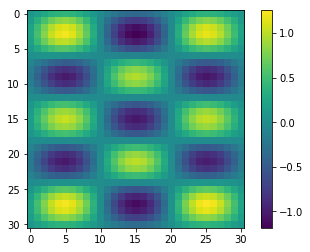

In [22]:
plt.imshow(DMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

**Plot Residual**

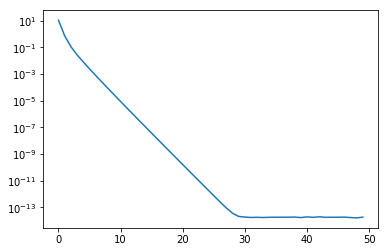

In [23]:
plt.semilogy(DMM_Res)

**Calculate Spectral Radius**

In [24]:
DMM_Radius = Rhonew
print('DMM_Radius = {}'.format(DMM_Radius))

DMM_Radius = 0.36632131282415953


R under log10(abs())


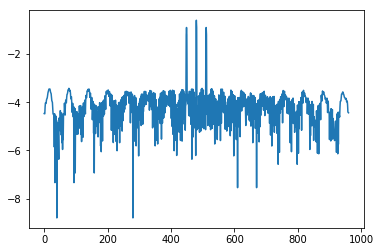

In [25]:
print("R under log10(abs())")
plt.plot(np.log10(np.abs(Rnew))[round(0.5*outputsize)][:])

## DMM with nine point scheme optimizer

**Build the stiff matrix**

In [26]:
num_levels=2
n=sqrtinputsize
kx = np.zeros([n,n+1])
ky = np.zeros([n+1,n])
for i in range(n):
    for j in range(n+1):
        kx[i][j] = a((j-0.5)*h,i*h)
for i in range(n+1):
    for j in range(n):
        ky[i][j] = a(j*h,(i-0.5)*h)    
A = gallery.nonlinearPoisson((n,n), kx, ky)

In [27]:
PR_stencil_type = "m9p"
gmm = dgmg.DeepMG(A, PR_stencil_type=PR_stencil_type, max_levels=num_levels)
num_iter = 2500
step_size = 1e-4
opt_par = gmm.optimize(num_iter=num_iter, step_size=step_size)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Iteration 100/2500
Upper bound estimation = 0.21584051270134524
Iteration 200/2500
Upper bound estimation = 0.205395627570143
Iteration 300/2500
Upper bound estimation = 0.19084219365671137
Iteration 400/2500
Upper bound estimation = 0.18065235357040862
Iteration 500/2500
Upper bound estimation = 0.17334725605550452
Iteration 600/2500
Upper bound estimation = 0.1649869477965006
Iteration 700/2500
Upper bound estimation = 0.16208532629694247
Iteration 800/2500
Upper bound estimation = 0.15323569177109758
Iteration 900/2500
Upper bound estimation = 0.14708292384586277
Iteration 1000/2500
Upper bound estimation = 0.14178254560585657
Iteration 1100/2500
Upper bound estimation = 0.1375473301704295
Iteration 1200/2500
Upper bound estimation = 0.13172233676894726
Iteration 1300/2500
Upper bound estimation = 0.12974590119982304
Iteration 1400/2500
Upper bound estimation = 0.13031603071705256
Iteration 1500/2500
Upper bound estimation = 0.12787421193288873
Iteration 1600/2500
Upper bound estima

In [28]:
print(gmm)
convergence = gmm.get_optimizer_convergence()
conv_time = gmm.get_optimization_time()
gmm.update_prd(opt_par)
DMM_rho = gmm.compute_rho()
print("DMM rho = {}".format(DMM_rho))

Dimension of matrix A for levels:
Level = 0, dimension = (15, 15)
Level = 1, dimension = (31, 31)

DMM rho = 0.11086683014608013


[9.73221087e+00 7.81349893e-01 7.82804667e-02 7.78736376e-03
 7.59746005e-04 7.31578427e-05 7.41205944e-06 8.00099450e-07
 8.39278001e-08 9.00165277e-09 9.77106137e-10 1.06380457e-10
 1.15976533e-11 1.26714986e-12 1.38079902e-13 2.07422490e-14
 1.21414485e-14 1.19167526e-14 1.10317377e-14 1.36056554e-14
 1.19214477e-14 1.31227310e-14 1.20708088e-14 1.25752383e-14
 1.14742535e-14 1.17607083e-14 1.08603201e-14 1.17180638e-14
 1.14745805e-14 1.13118658e-14 1.06892898e-14 1.14256502e-14
 1.06905831e-14 1.13397049e-14 1.00050549e-14 1.01678636e-14
 1.03103548e-14 1.21428888e-14 1.25402273e-14 1.29688285e-14
 1.40026360e-14 1.10677418e-14 1.09786525e-14 1.31675176e-14
 1.26164127e-14 1.25362567e-14 1.32220724e-14 1.23831935e-14
 1.32630808e-14 1.27722810e-14]


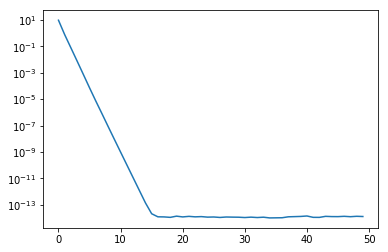

In [29]:
x = gmm.solve(RightF, np.random.randn(A.shape), tol=0, max_iter=50)
print(gmm.get_gmg_convergence())
plt.semilogy(gmm.get_gmg_convergence())

In [30]:
np.linalg.norm(Ureal - x,np.inf)

0.4097561189729527

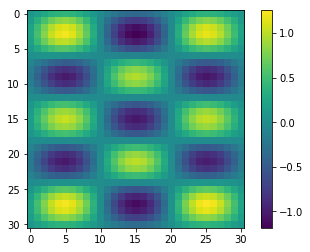

In [31]:
x = x.reshape(A.dim)
plt.imshow(x)
plt.colorbar()

In [32]:
np.set_printoptions(threshold=np.inf)
print("omega = {}".format(opt_par[2]))

omega = 0.7896362686573152


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log10
  return f_raw(*args, **kwargs)


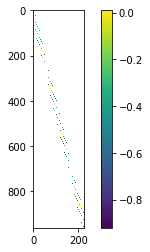

In [33]:
P = opt_par[0][0]
k = int(2**(np.log2(n+1)-1)-1) 
P_Matrix = np.zeros([n**2,k**2])
for i in range(k):
    for j in range(k):
        C = P[i][j]
        for l in range(3):
            for m in range(3):
                P_Matrix[n*(2*i+l)+(2*j+m)][k*i+j] = C[l][m]
plt.imshow(np.log10(np.abs(P_Matrix)))
plt.colorbar()

P under log10(abs())


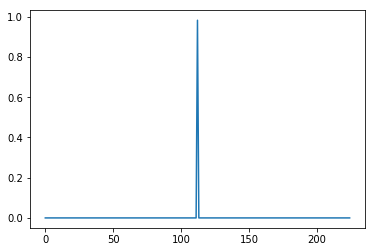

In [34]:
print("P under log10(abs())")
plt.plot(P_Matrix[round(0.5*inputsize)][:])

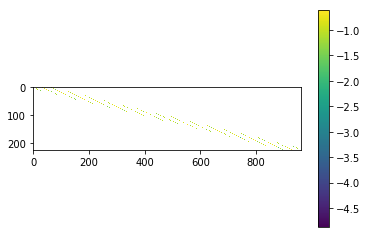

In [35]:
R = opt_par[1][0]
R_Matrix = np.zeros([k**2,n**2])
for i in range(k):
    for j in range(k):
        C = R[i][j]
        for l in range(3):
            for m in range(3):
                R_Matrix[k*i+j][n*(2*i+l)+(2*j+m)] = C[l][m]
plt.imshow(np.log10(np.abs(R_Matrix)))
plt.colorbar()

R under log10(abs())


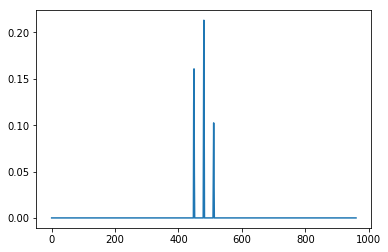

In [36]:
print("R under log10(abs())")
plt.plot(R_Matrix[:][round(0.5*outputsize)])

## Compare

Text(0, 0.5, 'Residual')

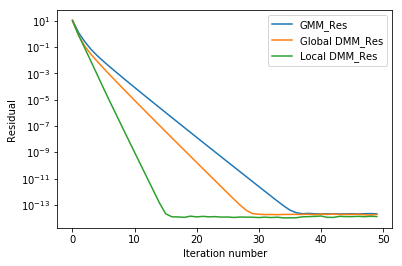

In [37]:
plt.semilogy(GMM_Res, label = 'GMM_Res')
plt.semilogy(DMM_Res, label = 'Global DMM_Res')
plt.semilogy(gmm.get_gmg_convergence(), label = 'Local DMM_Res')
plt.legend(loc='upper right')
plt.xlabel('Iteration number')
plt.ylabel('Residual')